## ENVM 1502 -River Basin Hydrology and Water Management (2022/23 Q3)
- [Anne Versleijen](https://github.com/anneversleijen) (4542893)
- [David Haasnoot](https://github.com/Daafip)  (4897900)

### loading packages

In [1]:
import os
import glob
import math
import warnings
import datetime
import regionmask
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import theilslopes

# webscraping Q data
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os

# plotting/mapmaking
import rasterio
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
from rasterio.plot import show as rioshow
from ismn.interface import ISMN_Interface
from cartopy.io.img_tiles import OSM
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# own geospatial functions
from geospatial_functions import get_background_map
from geospatial_functions import reproject_raster
from geospatial_functions import remove_below_0

### specifiying directories

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'
data_folder_grace = f'{home_path}\\Data\\Grace'
soil_moisture_path  = f'{os.path.dirname(path)}\\Data\\Soilmoisture'
ENVM1502_link_path = os.path.dirname(os.path.dirname(os.path.dirname(path)))
ENVM1502_data_path = f'{ENVM1502_link_path}\\Unit 2\\Ex3 - Soil moisture\\'

### loading needed geospatial layers
these are prepared using data from hydrosheds and dem data

In [3]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
gdf_thiessen      = gpd.read_file(f'{gis_folder}\\Thiessen_prcp.shp',crs="EPSG:26918")
outline_buffered  = gpd.read_file(f"{gis_folder}\\hudson_basin_buffered.gpkg",crs="EPSG:26918")

# fixing crs
for layer in [outline,main_rivers,all_rivers, gdf_thiessen,outline_buffered]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# More indepth analyses & data can be found on [github](https://github.com/Daafip/ENVM1502-Catchment-model)

# 0. Dataset 
## 0.1.1 & 2 - P

All data is downloaded from:  https://www.ncei.noaa.gov/cdo-web/. The raw data file is too large to be stored, individual station data can be found [here](https://github.com/Daafip/ENVM1502-Catchment-model/tree/main/Data/P/data%20per%20station) in the repo. 

Initially the mean over the whole area was taken, however this removes the peaks. To combat this thiessen polygons were made to make a better representation of the data. This can be found in notebook [0.1.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.1.2.P_splitting_into_theissen.ipynb)

**load in station data:**

In [4]:
df_lst_input = []
station_lst = []
station_index_dict= {}

files = glob.glob(f"{data_folder}\\P\\data per station\\*_prcp.csv")
for index, file in enumerate(files):
    df = pd.read_csv(file, index_col='DATE', usecols=['DATE', 'PRCP', 'STATION', 'LATITUDE', 'LONGITUDE'],  delimiter=',', parse_dates=True)
    station_lst.append([df.iloc[0].STATION,df.iloc[0].LATITUDE, df.iloc[0].LONGITUDE])
    df_lst_input.append(df)
    station_index_dict[f"{df.iloc[0].STATION}"] = index

**combine raw data into layer**

In [5]:
station_arr = np.array(station_lst)
df_stations = pd.DataFrame(data=list(zip(station_arr[:,0], station_arr[:,1],station_arr[:,2])),
                           columns = ['STATION', 'LATITUDE', 'LONGITUDE'],)

geom  = gpd.points_from_xy(df_stations.LONGITUDE,df_stations.LATITUDE)
gdf_stations = gpd.GeoDataFrame(data=df_stations,geometry=geom, crs="EPSG:4326")
gdf_stations_in_area = gdf_stations[gdf_stations.within(outline.iloc[0].geometry)]

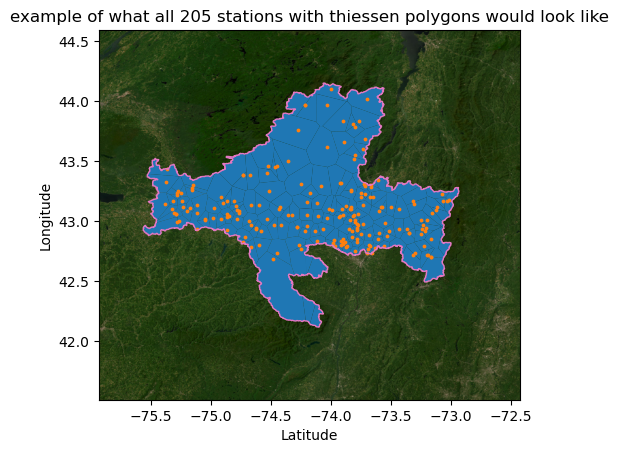

In [6]:
fig, ax = plt.subplots(1)
gdf_thiessen.plot(ax=ax)
gdf_stations_in_area.plot(ax=ax,color="C1",markersize=3) .plot()
outline.plot(ax=ax,edgecolor="C6",facecolor="None")
ax.set_title(f"example of what all {len(gdf_stations_in_area)} stations with thiessen polygons would look like")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

# add background
bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
with rasterio.open(get_background_map("P_stations", bounds_stations)) as r:
    rioshow(r, ax=ax,zorder=-10);

in reality not all stations have data at once, only 4 stations stand between 1950 and 2020, to combat this, we create thiessen polygons for all combinations of stations

In [7]:
gdf_joined = gdf_stations_in_area.sjoin(gdf_thiessen)
lst_dfs_concat = []
for i in gdf_joined.index:
    station_name = gdf_joined.loc[i,"STATION"]
    station_area = gdf_joined.loc[i,"area"]
    df = df_lst_input[station_index_dict[station_name]][["PRCP"]].copy()
    df.rename(columns={'PRCP':f'{station_name}'},inplace=True)
    lst_dfs_concat.append(df)
df_combined = pd.concat(lst_dfs_concat, axis=1)

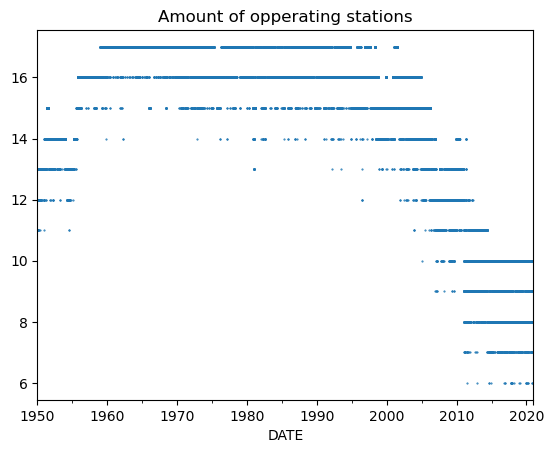

In [8]:
n_year = 50 # threshold for the number of years to be opperating
df_selected_combined = df_combined.loc["1950":"2020"].dropna(axis=1,thresh=365*n_year)
count_nans = df_selected_combined.apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)
(len(df_selected_combined.columns)- count_nans).plot(lw=0,marker=".",ms=1)
plt.title("Amount of opperating stations");

to speed thing up the threshold was lowered in this case, but a threshold of 20 continous years was used to generate the data set. An example is given below of how the polygon code looks 

In [9]:
# code to create thiessen polygons
from longsgis import voronoiDiagram4plg
def draw_thiessen_polygons(stations, boundary):
    """https://pypi.org/project/voronoi-diagram-for-polygons/"""
    warnings.filterwarnings("ignore", category=FutureWarning)
    vd = voronoiDiagram4plg(stations, boundary)
    return vd

In [10]:
columns = np.array(df_selected_combined.columns.to_list())
series_stations_not_na_txt = df_selected_combined.apply(lambda x: ','.join(columns[~np.isnan([x.loc[col] for col in x.index])]),axis=1)
df_stations_not_na_txt = pd.DataFrame(data=series_stations_not_na_txt,columns=["names_station"])
total_area = outline.to_crs("EPSG:26918").area.sum()
lst_df_joined = []
dict_df_joined = {}
for index, combination in enumerate(df_stations_not_na_txt['names_station'].unique()[:1]):
    ids_to_thiessen = combination.split(",")
    df_station_to_thiessen = gdf_stations_in_area.set_index("STATION").loc[ids_to_thiessen]
    thiessen_polygons = draw_thiessen_polygons(df_station_to_thiessen, outline)
    thiessen_polygons = thiessen_polygons.to_crs("epsg:26918")
    df_station_to_thiessen = df_station_to_thiessen.to_crs("epsg:26918")
    thiessen_polygons["Area_m2"] = thiessen_polygons.area
    df_joined = df_station_to_thiessen.sjoin(thiessen_polygons)
    
    # save the outputs to be used later, dict to get the index, list to store the data
    lst_df_joined.append(df_joined)
    dict_df_joined[combination] = index

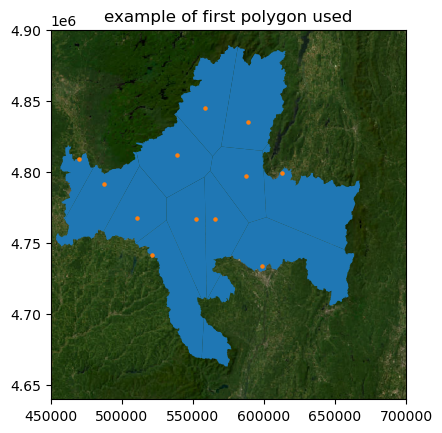

In [11]:
fig, ax = plt.subplots(1)
df_station_to_thiessen.plot(ax=ax, color="C1",zorder=10,markersize=5)
thiessen_polygons.plot(ax=ax)
ax.set_title("example of first polygon used")
    
# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)
    
ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

With the polygons generated the data can then be added by multiplyin P with the fraction & summing

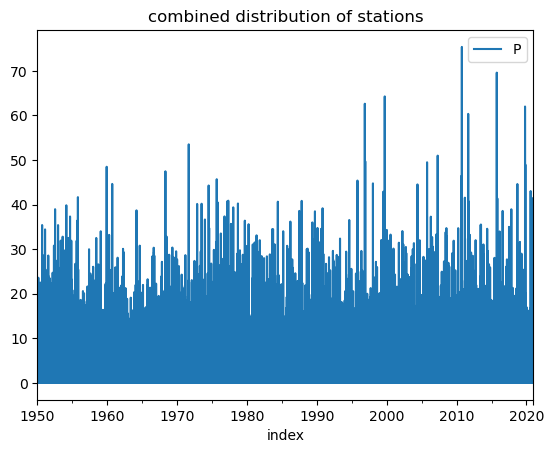

In [12]:
df_p = pd.read_parquet(f"{data_folder}\\P\\weighted_average_P.parquet")

fig, ax = plt.subplots(1)
df_p.plot(ax=ax)
ax.set_title("combined distribution of stations");

## 0.1.3 - T

Similar to P, T was loaded in from station data obtained from https://www.ncei.noaa.gov/cdo-web/. More info in notebook [0.1.3](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.1.3.T_combining_selected_data.ipynb)

In [13]:
gdf_stations = gpd.read_file(f'{gis_folder}\\location_temperature_stations_upperbains_26918.gpkg')

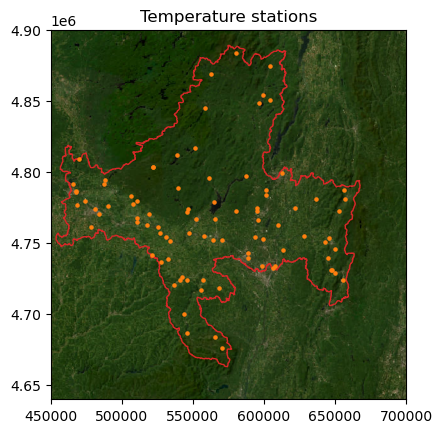

In [14]:
fig, ax = plt.subplots(1)
gdf_stations.plot(ax=ax, color="C1",zorder=10,markersize=5)
outline.to_crs("epsg:26918").plot(ax=ax,edgecolor='C3',facecolor="none")
ax.set_title("Temperature stations")
    
# add background
old_outline_path = get_background_map("outline", bounds_stations)
background_epsg26918 = reproject_raster(old_outline_path, "epsg:26918",ending="tif")
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-10)
    
ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));

In [15]:
df_station_ids = gdf_stations[["station ID"]].rename(columns={"station ID":"station_id"})
lst_t_dfs_max = []
lst_t_dfs_min = []
lst_elevation = []
for ids in df_station_ids.station_id.values:
    df_in = pd.read_parquet(f"{data_folder}\\T\\data parquet basin\\temp_{ids}.parquet")
    lst_elevation.append([ids,df_in["ELEVATION"].iloc[0]])
    df_in["DATE"] = pd.to_datetime( df_in["DATE"])
    df_in = df_in.set_index("DATE")
    df_in["TMAX"] = df_in["TMAX"].apply(lambda x: x if (x < 100) else np.nan)
    df_in["TMIN"] = df_in["TMIN"].apply(lambda x: x if (x < 100) else np.nan)
    df_in = df_in.rename(columns={"TMAX":f"TMAX_{ids}","TMIN":f"TMIN_{ids}"})
    df_in_max = df_in.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',f"TMIN_{ids}"])
    df_in_min = df_in.drop(columns=['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',f"TMAX_{ids}"])
    lst_t_dfs_max.append(df_in_max)
    lst_t_dfs_min.append(df_in_min)

In [16]:
df_combined_max = pd.concat(lst_t_dfs_max,axis=1)
df_combined_mean_max = df_combined_max.mean(axis=1)

df_combined_min = pd.concat(lst_t_dfs_min,axis=1)
df_combined_mean_min = df_combined_min.mean(axis=1)

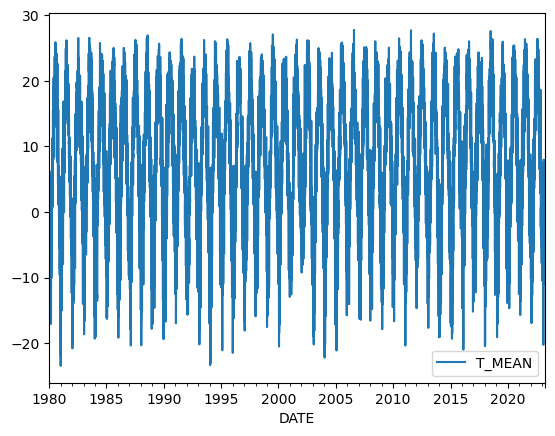

In [17]:
temp_mean_series = (df_combined_mean_max  +  df_combined_mean_min) /2
df_t = pd.DataFrame(data=temp_mean_series,columns=["T_MEAN"])
df_t.loc["1980":].plot();

# 0.2 Q

**From the USGS website we can extract hydrological units for the basin**<br>
[USGS Watershed Boundary Dataset (WBD) for 2-digit Hydrologic Unit - 02 (published 20230306) GeoPackage](https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/GPKG/WBD_02_HU2_GPKG.zip) using [USGS TNM Download (v2.0)](https://apps.nationalmap.gov/downloader/#/)
![iamge](Figures\wanted_hydrological_areas.png)

**The ids shown on the map can be loaded in**

In [18]:
gdf_wbdhu = gpd.read_file(f"{gis_folder}\\WBDHU8-hudson.gpkg",driver="GPKG",crs="EPSG:4326")  
huc8_ids = ",".join(gdf_wbdhu.huc8.values)
# However we only take the northern part
huc8_ids = ",".join(gdf_wbdhu.iloc[[0,2,3,4,8]].huc8.values)
huc8_ids

'02020002,02020003,02020004,02020001,02020005'

Which we can query

In [19]:
station_id_rest_query = f"https://waterservices.usgs.gov/nwis/dv/?format=rdb&huc={huc8_ids}&parameterCd=00060&siteType=ST&siteStatus=all"
page = urlopen(station_id_rest_query)
html_bytes = page.read()
html = html_bytes.decode("utf-8")

& process

In [20]:
# the 15th line contains the number of sites:
skip_rows = 15
line = html.split("\n")[skip_rows]
print(line)
n = int(line[line.find("following ")+len("following "):line.find(" site")].strip())

data = html.split("\n")[skip_rows+1:skip_rows+1+n]
data_ordered = []
for line in data:
    words = line[line.find("USGS"):].split(" ")
    type_id_name = words[:2] + [" ".join(words[2:])]
    data_ordered.append(type_id_name)
df_sites = pd.DataFrame(data=data_ordered,columns=["provider","site_no","name"])
df_sites.site_no = df_sites.site_no.astype(int)

df_sites.head(4)

# Data for the following 109 site(s) are contained in this file


provider    site_no                                               name
0     USGS  131199050  FISHING BROOK (COUNTY LINE FLOW OUTLET) NR NEW...
1     USGS    1311992                ARBUTUS POND OUTLET NEAR NEWCOMB NY
2     USGS    1312000                       HUDSON RIVER NEAR NEWCOMB NY
3     USGS    1313500        CEDAR R BELOW CHAIN LAKES NR INDIAN LAKE NY

for these site numbers we can get the location & plot them, see notebook [0.2.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.2.2.Q_webscrape%20locations%20.ipynb)

In [21]:
def plot_map(gdf_station, ax):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
        
    ax.set_xlim(-75.8,-72.8)
    ax.set_ylim(40.5, 44.5)
    # remove lat/lon markers
    # ax.set_xticks([])
    # ax.set_yticks([])

In [22]:
gdf_station = gpd.read_file(f"{gis_folder}\\discharge_stations.gpk", driver="GPKG")
# fixing indexing
gdf_station.index = gdf_station.apply(lambda x: int(x.site_no[1:]),axis=1)
gdf_station       = gdf_station.drop(columns=["site_no"])

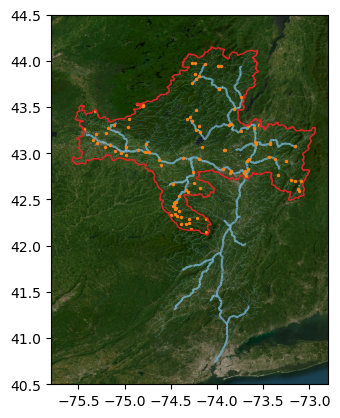

In [23]:
fig, ax = plt.subplots(1)
plot_map(gdf_station, ax)

These sites can then be loaded in, which can be found in notebook [0.2.3](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/0.2.3.Q_Loading%20discharge%20data.ipynb).<br>
We focussed on station 1358000 as this was at the bottom of the catchement closest to the outflow. 

In [24]:
begin_end_date_csv = f"{data_folder}\\Q_ids_with_begin-end-date.csv"
df_id_dates = pd.read_csv(begin_end_date_csv,index_col=0)
df_id_dates.set_index("ID",inplace=True)

lst_data   = []
lst_errors = []
found_ids  = []

for path in glob.glob(f"{data_folder}\\Q\\1*.parquet"):
    df = pd.read_parquet(path)
    # check columns integrity, else this will fail
    df = df[['agency_cd', 'site_no', 'Data codes', 'Q_m3_s_mean','date']]
    df.index = pd.to_datetime(df.date)
    df = df[df["Q_m3_s_mean"]>-999]
    site_no = int(str(df['site_no'].iloc[0])[1:])
    found_ids.append(site_no)
    area = df_id_dates.loc[site_no,"Area_m2"]
    df["Area_USGS"] = area
    df["Q_mm_d"]  = df["Q_m3_s_mean"]  * 86400 / area * 1000  # s -> d, m3 -> mm
    lst_data.append(df)

In [25]:
wanted_index = list(found_ids).index(1358000)
wanted_index

107

In [26]:
def plot_map(ax, station_id):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    
    # remove lat/lon markers
    ax.set_xticks([])
    ax.set_yticks([])
    
    # zoom on one station
    given_station = gdf_station.loc[[station_id]]
    given_station.plot(ax=ax, color="C4",markersize=40)
    x, y = given_station.geometry.x.iloc[0], given_station.geometry.y.iloc[0]
    n = 1
    ax.set_xlim(x- n,x + n)
    ax.set_ylim(y -(2*n/3),y + (2*n/3))


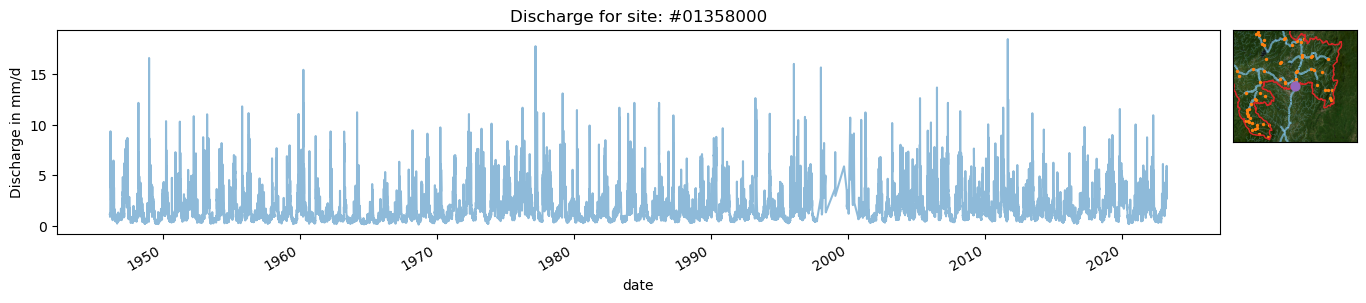

In [27]:
df = lst_data[wanted_index]
fig, ax = plt.subplots(1,figsize=(15,3))
ax2 = ax.inset_axes([.79,.45, 0.55,0.55])
plot_map(ax2, int(df["site_no"].iloc[0]))
df[['Q_mm_d']].plot(ax=ax, alpha=0.5)
ax.set_title(f'Discharge for site: #{df["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_ylabel("Discharge in mm/d");

after a closer look this gaues seems to be missing some data between 1997 & 2001

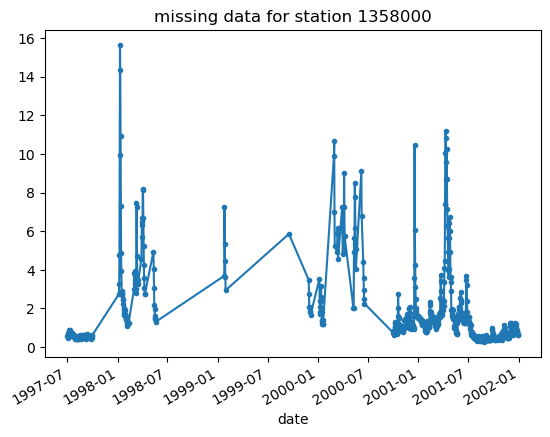

In [28]:
lst_data[wanted_index]["Q_mm_d"].loc["1997-07":"2001"].plot(marker=".")
plt.title("missing data for station 1358000");

Instead opt for adding two gauges together: 01357500 & 01335754 

![river_split](Figures\river_split.png) 

In [29]:
df_combined_E_W_path = glob.glob(f"{data_folder}\\Q\\combining_1357500_1335754.parquet")

df_combined_E_W = pd.read_parquet(df_combined_E_W_path[0], columns=['Q_m3_s_mean','date'])
df_combined_E_W.index = pd.to_datetime(df_combined_E_W.date)
df_combined_E_W.rename(columns={'Q_m3_s_mean':'Q'}, inplace=True)

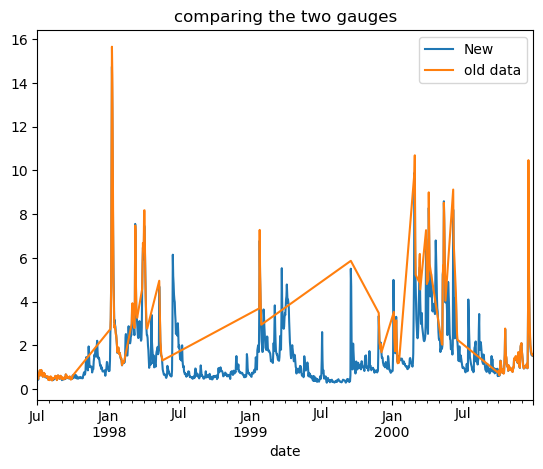

In [30]:
ax = df_combined_E_W["Q"].loc["1997-07":"2000"].plot(label="New")
lst_data[wanted_index]["Q_mm_d"].loc["1997-07":"2000"].plot(ax=ax,label="old data")
ax.legend()
ax.set_title("comparing the two gauges");

# 0.3 E_pot
-> handled in 2.5 & 2.6

# 0.4 Combining these four variables 

The gleam data is only availible from the 1980s so this is taken as the begin of the data period, full details in notebook [0.4]()

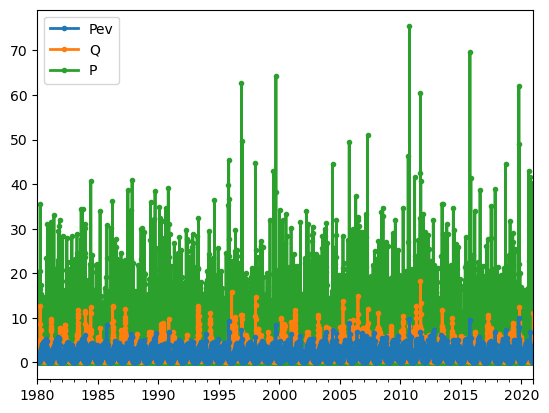

In [31]:
combined_forcing = pd.read_parquet(f"{data_folder}\\combined_data.parquet")
combined_forcing = combined_forcing.loc["1980":"2020"]
for i, col in enumerate(["Pev","Q","P"]):
    combined_forcing[col].plot(lw=2,marker=".",zorder=2-i,label=col)
plt.legend();

# 1.1 - Budyko

In [32]:
def budyko(df_data_1, show=True):
    df_data_1.dropna(inplace=True)
    df_data = df_data_1.copy()
    fig, ax = plt.subplots()
    
    #Calculate mean
    p_mean = df_data_1.P.mean()
    q_mean = df_data_1.Q.mean()
    ep_mean = df_data_1.Pev.mean()
    
    df_data_1['Ea_P'] = 1 - df_data_1['Q'] / df_data_1['P']
    
    EA_P = 1 - q_mean / p_mean
    EP_P  = ep_mean / p_mean
    
    EP_P_max = int(EP_P + 5)
    EP_P_array = np.linspace(1e-9, EP_P_max, EP_P_max*10)
    
    #Calculate theoretical Budyko
    budyko = (EP_P_array * np.tanh(1 / EP_P_array) * (1 - np.exp(-EP_P_array))) ** 0.5
    budyko_EP = (EP_P * np.tanh(1 / EP_P) * (1 - np.exp(-EP_P))) ** 0.5
    budyko_EA = budyko_EP * p_mean

    dS_dt = p_mean - q_mean - budyko_EA
    
    #Make figure
    ax.plot([0,1], [0,1], 'r')
    ax.plot([1, EP_P_max], [1, 1], 'b')
    ax.set_xlabel('$E_p$/P [-]')
    ax.set_ylabel('$E_A$/P [-]')

    ax.set_title(f'Long term water balance, dS/dT = {dS_dt:.2f} ')
    ax.plot(EP_P, EA_P, 'o', label=f'Partioning point GLEAM data')
    ax.plot(EP_P_array, budyko, '--', alpha=0.6, label=f'Budyko (1948) ')
    ax.legend()
    
    if show != True:
        plt.close()

    return df_data, dS_dt

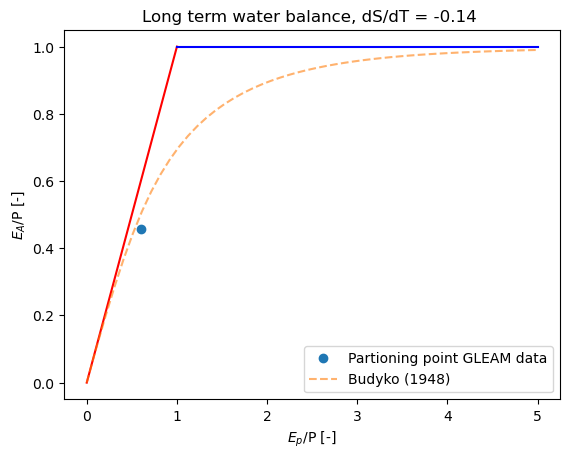

In [33]:
long_term, dS_dt  = budyko(combined_forcing)

In [34]:
def flow_duration(df, ax, show=True):
    
    df['Q'].dropna(inplace=True) #Drop the nan values
    df_q = df[["Q"]].rename(columns={"Q":"R"})
    
    df_q.sort_values("R",ascending=False,inplace=True)
    df_q = df_q.reset_index().reset_index()
    df_q.set_index("index",inplace=True)
    df_q.rename(columns={"level_0":"m"}, inplace=True)
    
    n = len(df_q)
    df_q['m'] = df_q.apply(lambda x: x.m+1, axis=1)
    df_q['p'] = df_q.apply(lambda x: x.m / (n+1), axis=1)
    
    # fig, ax = plt.subplots(2,1,figsize=(6,8))
    # fig.tight_layout(h_pad=6)
    
    ax[0].set_ylabel("Runoff Q in [$mm/d$]")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    df[["Q"]].plot(ax = ax[0], color="C0", xlabel='Date')
    
    ax[1].set_ylabel("Runoff Q in [$mm/d$]")
    ax[1].set_xlabel("Excedance probability [-]")
    ax[1].set_title(f"Run off exceedance probability ")
    ax[1].set_yscale("log")
    ax[1].grid()
    ax[1].plot(df_q.p, df_q.R, color="C0")
    
    if show != True:
        plt.close()

    return df_q

In [35]:
def auto_correlation(df, ax, show=True):
    df.dropna(inplace=True)
    lag = range(50)
    corr_coeff_1 = []
    
    #calculate correlation coefficient for different time lags
    for i in lag:
        corr_coeff_1.append(df['Q'].autocorr(lag=i))
    
    #plot discharge and results
    # fig, ax = plt.subplots(2,1, figsize=(6, 8))
    # fig.tight_layout(h_pad=6)
    df['Q'].plot(ax=ax[0],color="C0")

    ax[0].set_ylabel("Runoff Q in [$mm/d$]")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    
    
    ax[1].plot(lag, corr_coeff_1, color="C0")
    
    ax[1].set_ylabel("Correlation Coefficient $[-]$")
    ax[1].set_xlabel("Time lag $[d]$")
    ax[1].set_title(f"Catchment")
    ax[1].grid()
    
    if show != True:
        plt.close()
    
    return corr_coeff_1

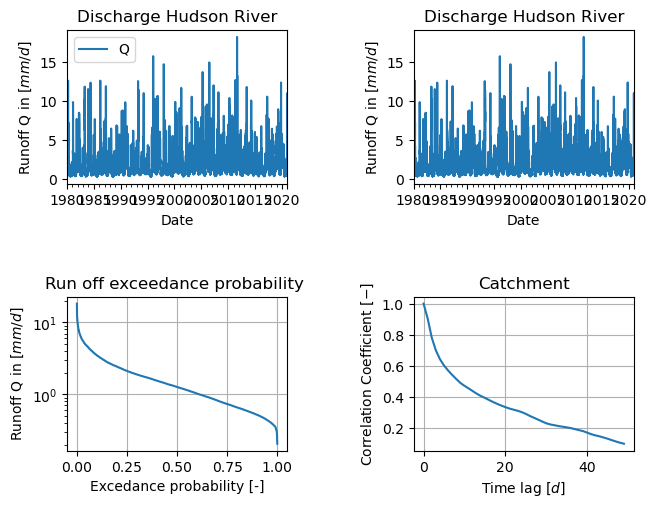

In [36]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(h_pad=6, w_pad=6)
_ = flow_duration(combined_forcing, [ax[0][0],ax[1][0]])
_ = auto_correlation(combined_forcing,[ax[0][1],ax[1][1]])

# 1.2 - Extreme value analysis

In [37]:
prcp_df = combined_forcing[["P"]].copy()
prcp_df.dropna()
prcp_df.rename(columns={"P":"PRCP"},inplace=True)
prcp_df = prcp_df[prcp_df.index >  pd.Timestamp("1892-08-01")] # skip gap in data

In [38]:
def annual_maxima(data):
    idx_max = data.groupby(data.index.year)['PRCP'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

In [39]:
df_prcp_maxima = annual_maxima(prcp_df).sort_values("PRCP",ascending=False)
df_prcp_maxima.index.name = "time"
df_prcp_maxima.head()

PRCP
time                 
2010-10-01  75.381120
2015-09-30  69.611906
1999-09-17  64.277034
1996-11-09  62.635524
2019-10-17  62.010101

Calculate emperical statistics for these maxima

In [40]:
#exercise, calculate N and expand you annual maxima dataframe with the columns i, p, q, y, T_a
M = len(df_prcp_maxima)

# indexing tricks to obtain i 
df_prcp_maxima_ranked = df_prcp_maxima.copy().reset_index().reset_index()
df_prcp_maxima_ranked.set_index("time", inplace=True)
df_prcp_maxima_ranked['i'] = df_prcp_maxima_ranked.apply(lambda x: int(x['index']) + 1, axis=1)
df_prcp_maxima_ranked.drop(columns=['index'],inplace=True)

# use i to obtain p
df_prcp_maxima_ranked['p'] = df_prcp_maxima_ranked.apply(lambda x: int(x.i) / (M+1), axis=1)
# q = 1-p
df_prcp_maxima_ranked['q'] = df_prcp_maxima_ranked.apply(lambda x: 1 - x.p, axis=1)

# to compute y = -ln(-ln(q))
df_prcp_maxima_ranked['y'] = df_prcp_maxima_ranked.apply(lambda x: -np.log(-np.log(x.q)), axis=1)

# obtain T_a with 1/p 
df_prcp_maxima_ranked['T_a'] = df_prcp_maxima_ranked.apply(lambda x: 1 / x.p, axis=1)

Calculate statistics for gumbel & fit 

In [41]:
# exercise: compute Gumbel parameters (name them sigma and mu)
annual_maxima_df_sorted = df_prcp_maxima_ranked.copy()
s_R = annual_maxima_df_sorted['PRCP'].std()
s_y = annual_maxima_df_sorted['y'].std()
y_gem = annual_maxima_df_sorted['y'].mean()
R_max_gem = annual_maxima_df_sorted['PRCP'].mean()

sigma = s_R / s_y
mu = R_max_gem - s_R * y_gem / s_y

print(f'scale parameter σ =  {sigma:.3f}')
print(f'location parameter µ = {mu:.3f}')

scale parameter σ =  10.490
location parameter µ = 35.052


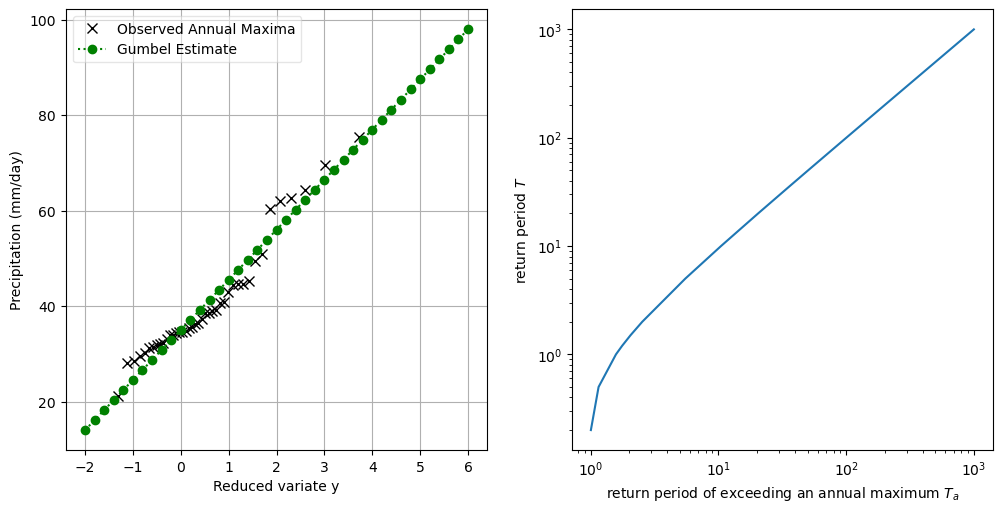

In [42]:
# Now we can construct the Gumbel fit and plot the Gumbel line
dummy_y = np.arange(-2,6.01,0.2)
R_Gumbel = sigma * dummy_y + mu

fig, [ax,ax2] = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(w_pad=3)

ax.plot(annual_maxima_df_sorted['y'].values, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(dummy_y, R_Gumbel, \
        ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

# Here we define the return periods and we inspect the difference between the two return periods
T_interest = np.asarray([0.2, 0.5, 1, 1.2, 1.5, 2, 5, 10, 20, 35, 50, 100, 200, 500, 1000])
T_a_interest = 1 / (1-np.exp(-1/T_interest))
ax2.loglog(T_a_interest,T_interest)
ax2.set_xlabel('return period of exceeding an annual maximum $T_a$')
ax2.set_ylabel('return period $T$')

# real return period for the observed annual maxima
# T_a = 1 / p
# annual_maxima_df_sorted.loc[:,'T_a'] = T_a
# T = -1 / np.log(1 - 1/annual_maxima_df_sorted['T_a'].values)
# annual_maxima_df_sorted.loc[:,'T'] = T
annual_maxima_df_sorted['T'] = df_prcp_maxima_ranked.apply(lambda x: -1 / np.log(1 - (1/ x["T_a"])), axis=1)


In [43]:
gumbel_estimate = sigma * (- np.log(1/T_interest)) + mu
T = annual_maxima_df_sorted['T'].values

In [44]:
import mevpy as mev # only works when this "Mevpy" folder is in the folder of this .ipnyb-file (https://github.com/EnricoZorzetto/mevpy)

In [45]:
# fit GEV parameters (withhout overwriting the sigma and mu from Gumbel)
AMS = annual_maxima_df_sorted['PRCP'].values
xi, sigma_gev, mu_gev = mev.gev_fit(AMS)

F_interest = np.exp(-(1/T_interest))*(1/T_interest)**0

# calculate the GEV estimate for our return periods of interest
gev_estimate = mev.gev_quant(F_interest, xi, sigma_gev, mu_gev)

# convert to dataframe and make a nice table
df_gev_estimate = pd.DataFrame(gev_estimate,columns=['GEV estimate (mm/day)'])
df_gev_estimate.index = T_interest # Return Period

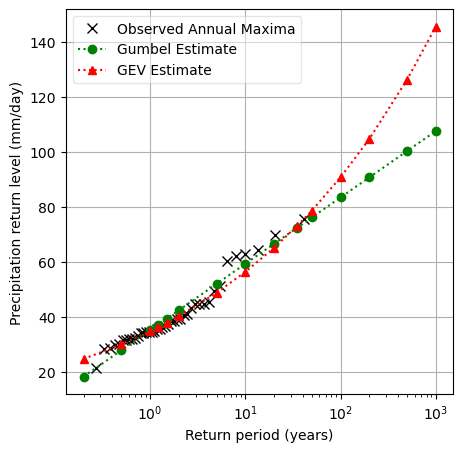

In [46]:
# create the figure
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(T, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
# ax.plot(T_interest[:-4], full_series, ':Pb', markersize=7, label = 'Full series')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

In [47]:
prcp_df["YEAR"] = prcp_df.index.year

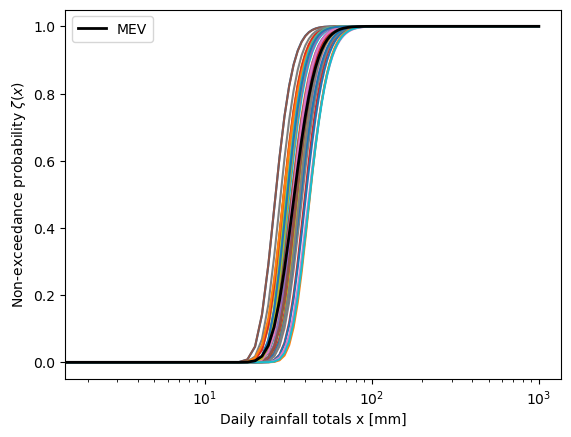

In [48]:
# fit mev parameters for each year
N, C, W =  mev.mev_fit(prcp_df, threshold=1)

# put this into a nice dataframe
df_params_mev = pd.DataFrame([N,C,W]).transpose()
df_params_mev.columns = ['N','C','W']

# plotting the CDF curves
dummy_X = np.arange(0,1000,2)

# non-exceedance probability for individual years (here defined as H)
H = np.zeros((len(dummy_X),M))
zeta = np.zeros((len(dummy_X)))

# continue with your own code here:
for i in range(len(zeta)):
    x = dummy_X[i]
    lst = []
    for j in range(len(W)):
        lst.append((1 - np.exp(-(x/C[j])**W[j]))**N[j])
    zeta[i] = 1 / M * np.sum(lst)
    
# x = dummy_X[0]
for j in range(M):
    for i in range(len(H)):
        x = dummy_X[i]
        H[i,j] = (1 - np.exp(-(x/C[j])**W[j]))**N[j]

# plot figure like in Enrico's paper
fig, ax = plt.subplots()
ax.plot(dummy_X, H)
ax.plot(dummy_X, zeta, 'k', linewidth=2, label='MEV')
ax.set_xlabel('Daily rainfall totals x [mm]')
ax.set_ylabel('Non-exceedance probability $\zeta(x)$')
ax.set_xscale('log')
ax.legend();

In [49]:
# obtain the MEV solution
x0 = np.mean(AMS)
mev_estimate, flags =  mev.mev_quant(F_interest, x0, N, C, W)

if any(flags) == True:
    print('Change starting guess for the numerical solution x0')
elif any(flags) == False:
    print('No errors have been raised, continue the exercise')

No errors have been raised, continue the exercise


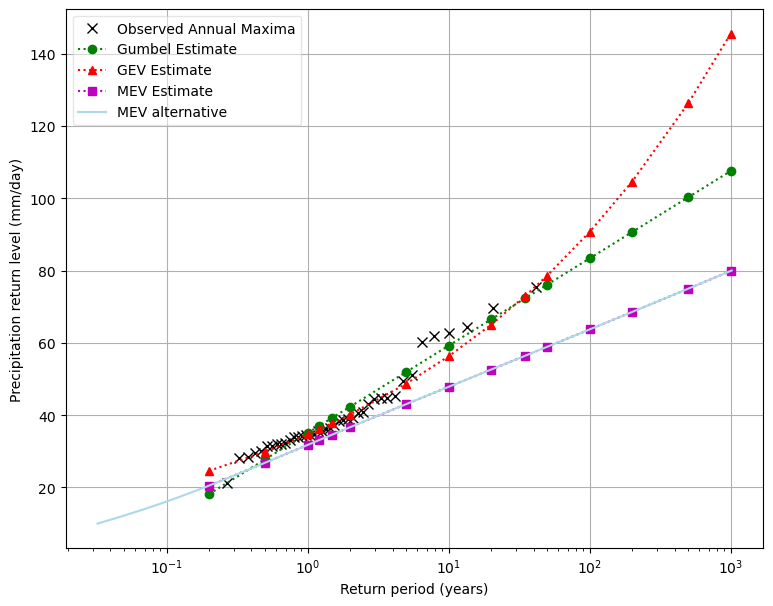

In [50]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
# & including the MEV alternative:
# return periods for the CDF curves
Ta_c = 1/(1-zeta)
T_c  = -1/(np.log(1-(1/Ta_c)))

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, annual_maxima_df_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
mask = (T_c<1100) & (T_c > 0)
ax.plot(T_c[mask], dummy_X[mask], 'lightblue', label='MEV alternative')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True);

# 1.3 - Vegetation

In [51]:
def water_balance(P, EP, Si_max):

    Si = np.zeros(len(P))
    Pe = np.zeros(len(P))
    for i in range(1, len(P)):
        Si[i] = Si[i-1] + P[i] 


        if Si[i] > Si_max:
            Pe[i] = Si[i] - Si_max
            Si[i] = Si[i] - Pe[i]

        Si[i] = Si[i] - EP[i]
        if Si[i] < 0:
            Si[i] = 0

    df = pd.DataFrame()
    df['P'] = P
    df['EP'] = EP
    df['Si'] = Si
    df['Pe'] = Pe
    return df

def vegetation(df_in, show=True):
    df = df_in.copy()
    df.dropna(inplace=True)
    
    Si_max = 2.5 # mm
    df_wb = water_balance(df.P, df.Pev, Si_max)

    mean_P = df_wb['P'].mean()
    mean_Pe = df_wb['Pe'].mean()
    ratio = mean_Pe / mean_P
    
    #Plot results
    fig, ax = plt.subplots(2, figsize=(10,6))
    df_wb['P'].plot(ax=ax[1])
    df_wb['Pe'].plot(ax=ax[1], ylabel='[mm/d]')

 
    
    df['P'].plot(ax=ax[0], xlabel='Date', ylabel='[mm/d]')
    df['Pev'].plot(ax=ax[0], xlabel='Date', ylabel='[mm/d]')
    df['Q'].plot(ax=ax[0], xlabel='Date', ylabel='[mm/d]')
    
    ax[0].legend() 
    ax[0].set_title(f'Precipitation, Potential Evaporation and Discharge Hudson Basin')
    
    ax[1].set_xlabel('Date')
    ax[1].set_title(f'Interception, with a throughfall ratio of {ratio:.2f}')
    ax[1].legend()
    fig.tight_layout(h_pad=4)
    
    if show != True:
        plt.close()
        
    return ratio, df_wb


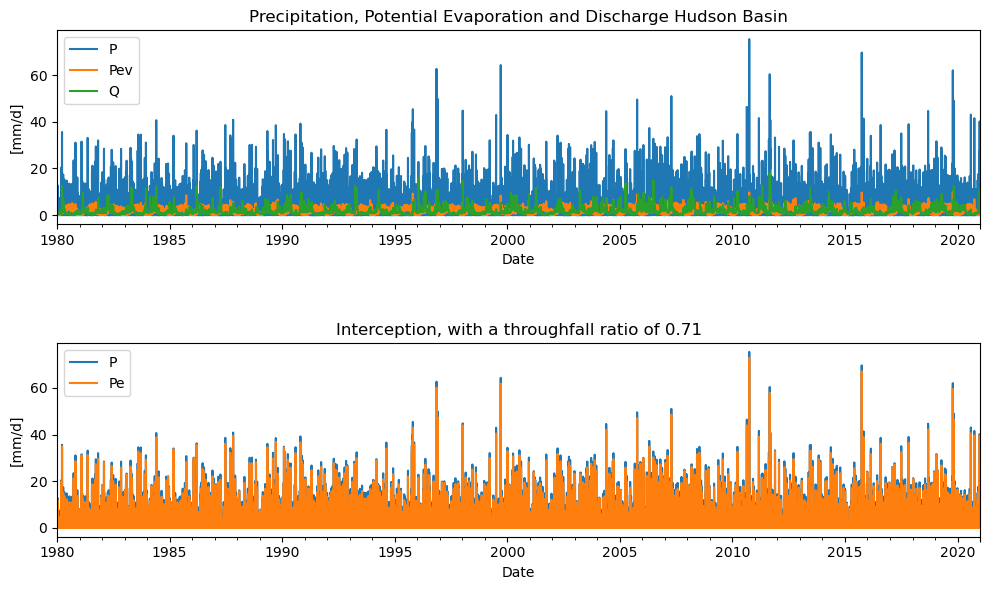

In [52]:
ratio, df = vegetation(combined_forcing)

In [53]:
def plant_transpiration(df_in, show=True):
    df = df_in.copy()
    df.dropna(inplace=True)
    
    P_mean = df['P'].mean()
    Q_mean = df['Q'].mean()
    Et_dash = P_mean - Q_mean
    EP_mean = df['Pev'].mean()
    
    df['Et'] = df['Pev'] / EP_mean * Et_dash
    df['Sd'] = np.zeros(len(df['P']))
    
    cumsum = 0 
    
    for i in df['Et'].index:
        cumsum += (df.loc[i,"P"] - df.loc[i,'Et'])
        if cumsum > 0:
            cumsum = 0
        df.loc[i,"Sd"] = np.minimum(0, cumsum)
    
    unique_years = len(df.index.year.unique())
    
    Sr = min(df['Sd'])
    Sr_index = df['Sd'].idxmin()
    
    EP_P = EP_mean / P_mean
    Et_P =  df['Et'].mean() / P_mean
    
    fig, ax = plt.subplots(2,figsize=(8,8))
    fig.tight_layout(h_pad=4)
    #ax2 = ax[0].twinx()  
    df['P'].plot(ax=ax[0], label='Precipitation')
    df['Pev'].plot(ax=ax[0], color='C1', label='Evaporation')
    
    ax[0].legend()
    #ax2.legend()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('[mm/d]');
    
    df['Sd'].plot(ax=ax[1], color='C3')
    ax[1].plot(Sr_index, Sr, 'ro')
    ax[1].text(Sr_index+datetime.timedelta(100), Sr, f'SR,{unique_years}y', fontsize=9)
    ax[1].legend()
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Storage deficit [mm]');
    
    if show == True:
        print(f'The vegetation-accessible water storage volume (or root-zone storage capacity) SR,y is {-Sr:.2f} [mm] over the preceding {unique_years} years')
    else:
        plt.close()
    
    return df, Sr, Et_P, EP_P

The vegetation-accessible water storage volume (or root-zone storage capacity) SR,y is 73.86 [mm] over the preceding 41 years


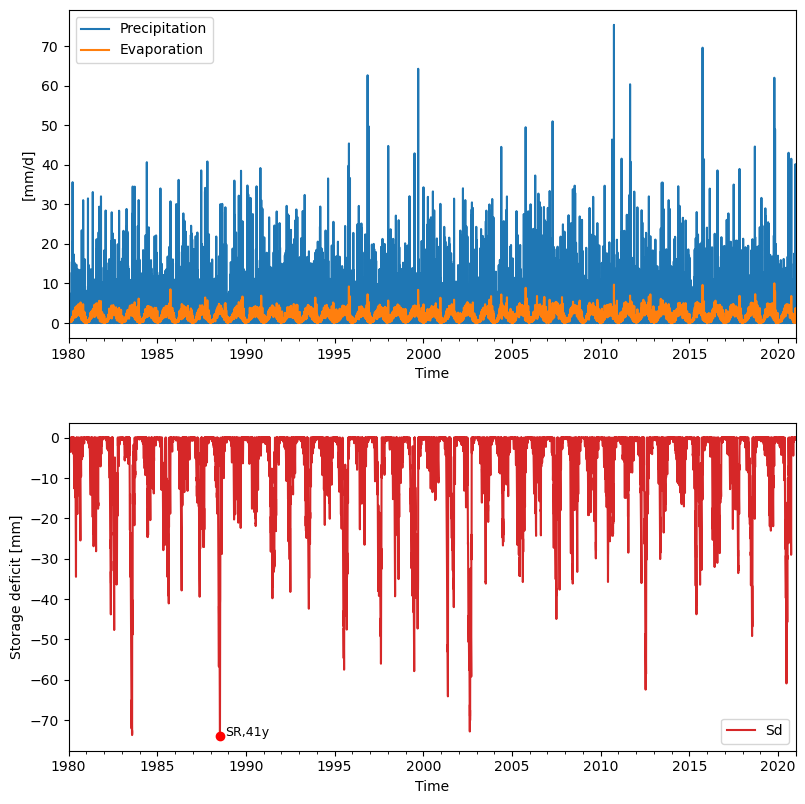

In [54]:
df, Sr, Et_P, EP_P = plant_transpiration(combined_forcing)

# 1.4

This only take from 1894, due to missing days and to remove the remove gap between 1988 and 1892

In [55]:
def align_zeros(axes):
    ylims_current = {}   #  Current ylims
    ylims_mod     = {}   #  Modified ylims
    deltas        = {}   #  ymax - ymin for ylims_current
    ratios        = {}   #  ratio of the zero point within deltas
    for ax in axes:
        ylims_current[ax] = list(ax.get_ylim())
                        # Need to convert a tuple to a list to manipulate elements.
        deltas[ax]        = ylims_current[ax][1] - ylims_current[ax][0]
        ratios[ax]        = -ylims_current[ax][0]/deltas[ax]
        
    for ax in axes:      # Loop through all axes to ensure each ax fits in others.
        ylims_mod[ax]     = [np.nan,np.nan]   # Construct a blank list
        ylims_mod[ax][1]  = max(deltas[ax] * (1-np.array(list(ratios.values()))))
                        # Choose the max value among (delta for ax)*(1-ratios),
                        # and apply it to ymax for ax
        ylims_mod[ax][0]  = min(-deltas[ax] * np.array(list(ratios.values())))
                        # Do the same for ymin
        ax.set_ylim(tuple(ylims_mod[ax]))

In [56]:
df_all_data_snow_model = combined_forcing.loc[pd.Timestamp("1894-01-01"):]

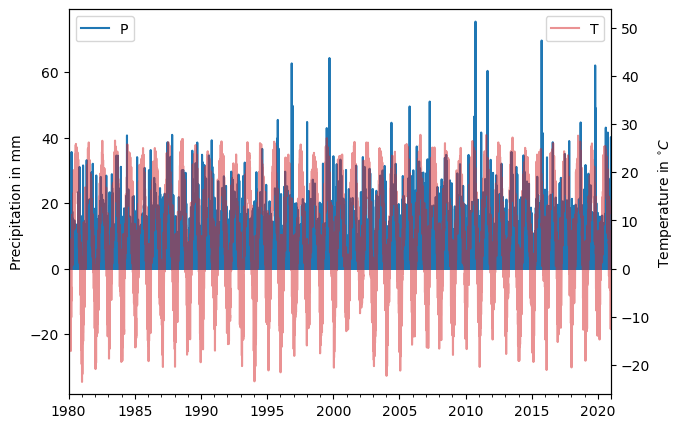

In [57]:
df_T_P = df_all_data_snow_model[["T","P"]].dropna(axis=0)

fig, ax = plt.subplots(1,1,figsize=(7,5),sharex=True)
df_T_P[['P']].plot(ax=ax,alpha=1)
ax.set_ylabel("Precipitation in mm")
ax.legend(loc="upper left")

ax2 = ax.twinx()
df_T_P[["T"]].plot(ax=ax2,color="C3",alpha=0.5,zorder=-10)
ax2.legend(loc="upper right")
ax2.set_ylabel("Temperature in $^{\circ}C$")

align_zeros([ax,ax2]);

**Consider elevation data as this correlates with snow**

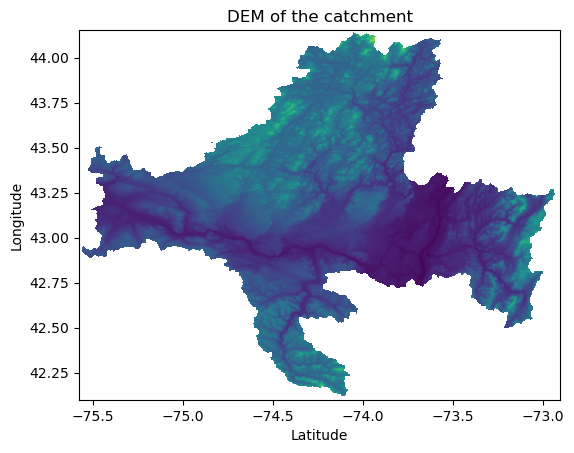

In [58]:
fig, ax = plt.subplots(1)
path = f'{gis_folder}\\basin_dem_SRTM.tif'
new_path = reproject_raster(path, "EPSG:4326")
with rasterio.open(new_path, driver='GTiff') as r:
        rioshow(r, ax=ax)
ax.set_title("DEM of the catchment")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

In [59]:
with rasterio.open(
    new_path,
    driver='GTiff',
    count=1,
    crs='EPSG:4326' 
                    ) as r:
    dem_data = r.read(1)

From the station data where the temperature is measured

In [60]:
load_lst_elevation = np.loadtxt(f'{data_folder}\\T\\elevation_stations.txt',delimiter=";",dtype=str)
lst_elevation = load_lst_elevation[:,1].astype(np.float64)

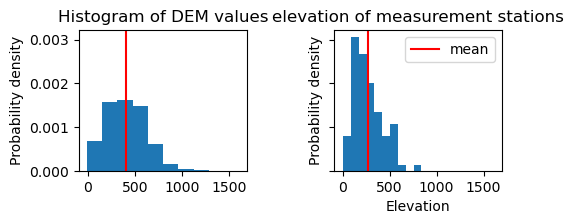

In [61]:
fig, [ax,ax2] = plt.subplots(1,2,sharex=True,sharey=True,figsize=(5,2))
fig.tight_layout(w_pad=4)

dem_data_in_basin = dem_data[dem_data>-999]
_, __, ___ = ax.hist(np.sort(dem_data_in_basin),density=True);
ax.axvline(np.mean(dem_data_in_basin),color="r")
ax.set_title("Histogram of DEM values")
ax.set_ylabel("Probability density")

_, __, ___ = ax2.hist(lst_elevation,density=True)
ax2.axvline(np.mean(lst_elevation),color="r",label="mean")
ax2.legend()
ax2.set_title("elevation of measurement stations");
ax2.set_ylabel("Probability density")
ax2.set_xlabel("Elevation");

The two histograms above show the distribution of the different elevations. In red the mean is shown. The dem and station measurements are fairly similar, though the stations measure a bit lower

**Start by taking the mean heights and the mean temperature as one flat plane**

In [62]:
def prev_date(date, days=1):    
    subtracted_date = pd.to_datetime(date) - datetime.timedelta(days=days)
    subtracted_date = subtracted_date.strftime("%Y-%m-%d")
    return subtracted_date

In [63]:
df = df_T_P.copy()

Er = lst_elevation.mean() #m 
Tt = -0.5 # degc
FM = 3    # mm/deg/d
S_0 = 0 # mm - no snow at start

# for every day:
dt = 1
for i, date in enumerate(df.index):
    P  = df.loc[date,"P"]
    TR = df.loc[date,"T"]
    if i == 0:
        df.loc[prev_date(date),"Ss"] = S_0 # initial amount snow (0) for non exisiting day
        
    # if below threshold temperature, assume not first day for similicity
    if TR < Tt and i != 0:
        df.loc[date,"Pr"] = 0                                                     # no rainfall
        df.loc[date,"Ps"] = P                                                     # precipitation is snow 
        df.loc[date,"M"]  = 0                                                     # Too cold for melt
        df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] + df.loc[date,"Ps"] * dt # add snow to the prev day
        df.loc[date,"Pl"] = 0                                                     # no outflow as too cold
    # then must be above
    else:
        df.loc[date,"Pr"] = P                                                     # all precip is rainfall
        df.loc[date,"Ps"] = 0                                                     # no snow 
        df.loc[date,"M"]  = min(df.loc[prev_date(date),"Ss"]/dt, FM * (TR - Tt))  # calculate melt
        df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] - df.loc[date,"M"] * dt  # remove melted snow
        df.loc[date,"Pl"] = df.loc[date,"Pr"] + df.loc[date,"M"]                  # outflow = rain + melt
        if i == 0:
            df.drop(index=prev_date(date),inplace=True) #  remove initial amount snow for non exisiting day
        
df_case1 = df.copy()

**plot for 1997-1999**

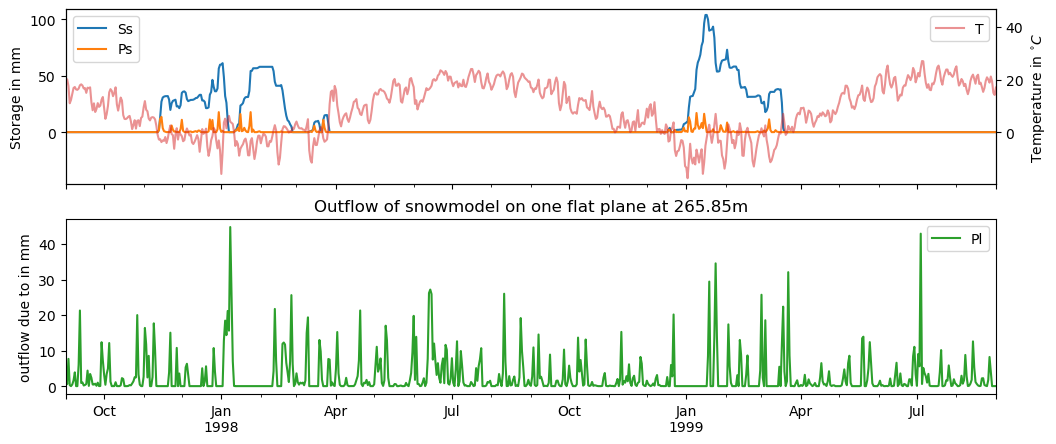

In [64]:
fig, [ax,ax3] = plt.subplots(2,1,figsize=(12,5),sharex=True)
df_plot = df_case1.loc["1997-09-01":"1999-09-01"]
df_plot[['Ss',"Ps"]].plot(ax=ax)
ax.set_ylabel("Storage in mm")
ax.legend(loc="upper left")

ax2 = ax.twinx()
df_plot[["T"]].plot(ax=ax2,color="C3",alpha=0.5,zorder=-10)
ax2.legend(loc="upper right")
ax2.set_ylabel("Temperature in $^{\circ}C$")

align_zeros([ax,ax2])

df_plot[['Pl']].plot(ax=ax3,color="C2")
ax3.set_ylabel("outflow due to in mm")
ax3.set_title(f"Outflow of snowmodel on one flat plane at {Er:.2f}m");

 **repeat but with different elevation bands**
 As we can see bellow, there is a spread of elevation from 0 to around 1000. these can be split into 4 bands:
1. `elevation < 250`
1. `250 < elevation < 500`
1. `500 < elevation < 750`
1. `750 < elevation`

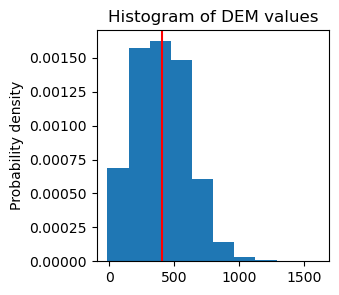

In [65]:
fig, ax = plt.subplots(1,sharex=True,sharey=True,figsize=(3,3))

dem_data_in_basin = dem_data[dem_data>-999]
_, __, ___ = ax.hist(np.sort(dem_data_in_basin),density=True);
ax.axvline(np.mean(dem_data_in_basin),color="r")
ax.set_title("Histogram of DEM values")
ax.set_ylabel("Probability density")
ax.annotate(f"$\mu$ ={np.mean(dem_data_in_basin):.1f}m",(np.mean(dem_data_in_basin)+12,0.002),color="red");

In [66]:
A1 = len(dem_data_in_basin[dem_data_in_basin<=250])/ len(dem_data_in_basin)
A2 = len(dem_data_in_basin[(dem_data_in_basin>250) & (dem_data_in_basin <=500)])/ len(dem_data_in_basin)
A3 = len(dem_data_in_basin[(dem_data_in_basin>500) & (dem_data_in_basin <=750)])/ len(dem_data_in_basin)
A4 = len(dem_data_in_basin[(dem_data_in_basin>750)])/ len(dem_data_in_basin)
print(f'A1:\t{A1:.2f}\nA2:\t{A2:.2f}\nA3:\t{A3:.2f}\nA4:\t{A4:.2f}\nΣ:\t{A1 + A2 + A3 + A4:.2f}')

A1:	0.26
A2:	0.40
A3:	0.28
A4:	0.05
Σ:	1.00


In [67]:
# for every day:
dt = 1

Er = 331  # m

heights = [125, 375, 625, 875] # m
A_lst = [A1, A2, A3, A4]
A = sum(A_lst)

lst_df         = []
lst_df_storage = []
for A_index, Ei in enumerate(heights): 
    df = df_T_P.copy()
    # compute for each day
    for i, date in enumerate(df.index):
        P  = df.loc[date,"P"]
        TR = df.loc[date,"T"]
        Ti = TR - 0.6 * (Ei-Er) / 100
        
        if i == 0:
            df.loc[prev_date(date),"Ss"] = S_0 # initial amount snow (0) for non exisiting day

        # if below threshold temperature, assume not first day for similicity
        if Ti < Tt and i != 0:
            df.loc[date,"Pr"] = 0                                                     # no rainfall
            df.loc[date,"Ps"] = P                                                     # precipitation is snow 
            df.loc[date,"M"]  = 0                                                     # Too cold for melt
            df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] + df.loc[date,"Ps"] * dt # add snow to the prev day
            df.loc[date,"Pl"] = 0                                                     # no outflow as too cold
        # then must be above
        else:
            df.loc[date,"Pr"] = P                                                     # all precip is rainfall
            df.loc[date,"Ps"] = 0                                                     # no snow 
            df.loc[date,"M"]  = min(df.loc[prev_date(date),"Ss"]/dt, FM * (Ti - Tt))  # calculate melt
            df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] - df.loc[date,"M"] * dt  # remove melted snow
            df.loc[date,"Pl"] = df.loc[date,"Pr"] + df.loc[date,"M"]                  # outflow = rain + melt
            if i == 0:
                df.drop(index=prev_date(date),inplace=True) #  remove initial amount snow for non exisiting day
    # for each height aggregate:
    fi = A_lst[A_index]/A
    df["Pl"] = df.apply(lambda x : x.Pl * fi, axis=1)
    df_out = df[["Pl"]].rename(columns={"Pl":f"Pl_{A_index+1}"})
    lst_df.append(df_out)
    
    df["Ss_scaled"] = df.apply(lambda x : x.Ss * fi, axis=1)
    df_storage_out = df[["Ss","Ss_scaled"]].rename(columns={"Ss":f"Ss_{A_index+1}","Ss_scaled":f"Ss_scaled_{A_index+1}"})
    lst_df_storage.append(df_storage_out)

df_case2 = pd.concat(lst_df + lst_df_storage, axis=1)
df_case2["Pl_tot"] = df_case2.apply(lambda x : x.Pl_1 + x.Pl_2 + x.Pl_3 + x.Pl_4, axis=1)
df_case2["Ss_tot"] = df_case2.apply(lambda x : x.Ss_scaled_1 + x.Ss_scaled_2 + x.Ss_scaled_3 + x.Ss_scaled_4, axis=1)

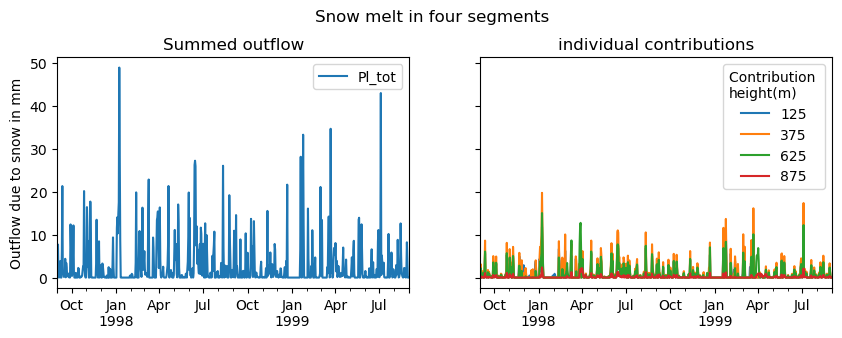

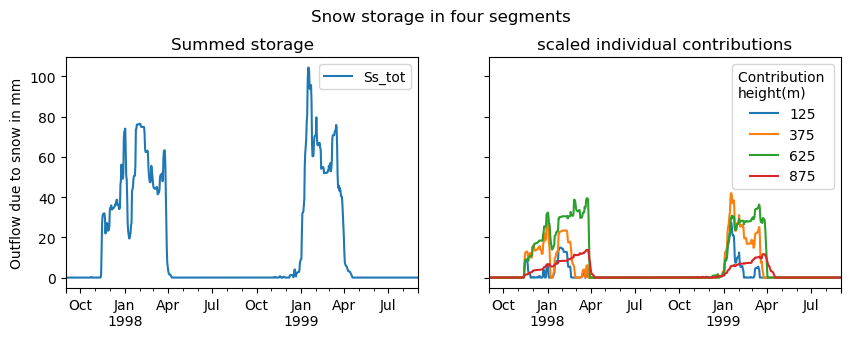

In [68]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,3))
fig.suptitle("Snow melt in four segments",y=1.04)

df_plot = df_case2.loc["1997-09-01":"1999-09-01"]
df_plot[['Pl_tot']].plot(ax=ax[0])
ax[0].set_ylabel("Outflow due to snow in mm")
ax[0].set_title("Summed outflow")
df_plot[['Pl_1','Pl_2','Pl_3','Pl_4']].plot(ax=ax[1])
ax[1].legend(heights,bbox_to_anchor=(1,1),title="Contribution \nheight(m)")
ax[1].set_title("individual contributions");

fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,3))
fig.suptitle("Snow storage in four segments",y=1.04)

df_plot = df_case2.loc["1997-09-01":"1999-09-01"]
df_plot[['Ss_tot']].plot(ax=ax[0])
ax[0].set_ylabel("Outflow due to snow in mm")
ax[0].set_title("Summed storage")
df_plot[['Ss_scaled_1','Ss_scaled_2','Ss_scaled_3','Ss_scaled_4']].plot(ax=ax[1])
ax[1].legend(heights,bbox_to_anchor=(1,1),title="Contribution \nheight(m)")
ax[1].set_title("scaled individual contributions");

You nicely see the storages increase and the difference per elevation band can also be seen nicely. The january melt in the 375m band shows up strongly in the the outflow peak.

# 1.5 - Flood routing

Can be found in notebook [1.5](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/1.5.Flood%20routing.ipynb)
takes long to run due to large data set. An example of the fit is given below:

![Muskingum](Figures/moddeld_vs_measure_muskin_routing.png)

# 1.6 - Moisture recycling
Can be found in notebook [1.6](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/1.6.Moisture_cycle.ipynb), no large insights, most of the mositure in the eastern united states comes from the ocean, likely also due to the gulfstream which passes by.

# 2.1 - Surface water classification

Landsat data can be downlaoded from https://earthexplorer.usgs.gov/, using landsat 8 level 2 in this case. 

This data is unprocessed datset very large and thus is not included, the results will be included.

Analysis is done in QGIS with the [
Semi-Automatic Classification Plugin](https://github.com/semiautomaticgit/SemiAutomaticClassificationPlugin)

The data from landsat can be imported, merged into one multiband layer and clipped to the basin area. The bands are remaped as shown in the legend to make water more visible (black). _Note: not all areas area covered, but optted for best fit_

This result is left below:     
![Figures\map_satelite_imaging.jpeg](Figures\map_satelite_imaging.jpeg)

The result of the plugin calssification using 10 examples of water and 10 of not water results in the following image:

In [69]:
cmap = mpl.cm.get_cmap("winter")
# loading the data in in 28918 crs
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   

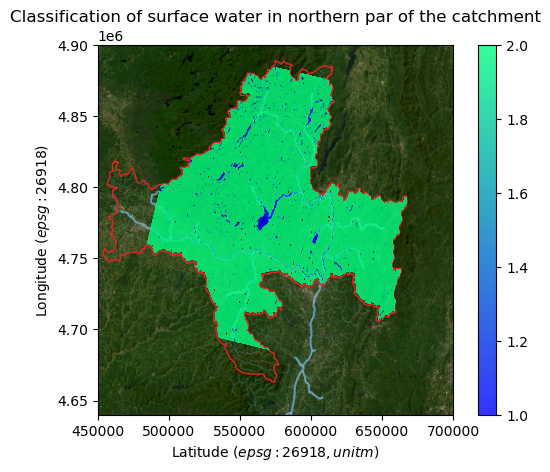

In [70]:
fixed_nans_path = remove_below_0(f'{gis_folder}\\classification_of_waterbodies_26918.tif',ending="tif")
fig, ax = plt.subplots(1)
with rasterio.open(fixed_nans_path, driver='GTiff') as r:
        img = rioshow(r, ax=ax,cmap=cmap,zorder=100,alpha=0.8)
ax.set_title("Classification of surface water in northern par of the catchment")
ax.set_xlabel("Latitude $(epsg:26918, unit m)$")
ax.set_ylabel("Longitude $(epsg:26918)$")

# add other features
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

# add background
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-100)

# fix color bar
im = img.get_images()[0]
fig.colorbar(im,ax=ax,cmap=cmap);

ax.set_xlim((4.5e5,7e5))
ax.set_ylim((4.64e6,4.9e6));


as some overlapt with rivers and some very small areas so these can be removed by only taking those larger than 10ha, the overlap remaining is merely the reservoirs built on the river rather than the actual course of the river. 
This can be further filtered to yield:

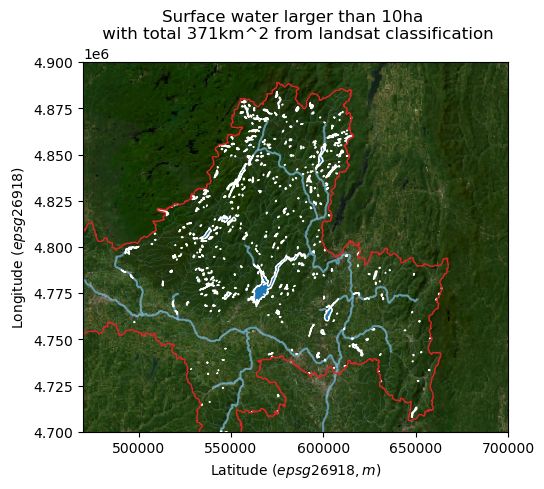

In [71]:
df_all_water_more10ha = gpd.read_file(f"{gis_folder}\\waterbodies_polygon_above10ha_excluding river.gpkg")
fig, ax  = plt.subplots(1)
df_all_water_more10ha.plot(facecolor="C0",ax=ax,edgecolor="w")

# add other features
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

# add background
with rasterio.open(background_epsg26918) as r:
    rioshow(r, ax=ax,zorder=-100)
    
ax.set_title(f"Surface water larger than 10ha \n with total {df_all_water_more10ha.area.sum()/10**6:.0f}km^2 from landsat classification")

ax.set_xlabel("Latitude $(epsg26918, m)$")
ax.set_ylabel("Longitude $(epsg26918)$")    
    
ax.set_xlim((4.7e5,7e5))
ax.set_ylim((4.70e6,4.9e6));

# fig.savefig(r"Figures/surfacewater_image.png")

# 2.2 - Remote Precipitation measurement
Not done due to time constraints, complexity in finding data & plenty of other availible prepitation data sources used to fullfill learning goals, see 2.6

# 2.3 - Soil moisture


### In situ
Inital parts for in situ soil measurement, downloaded from https://ismn.earth/en/data/, site [Lye Brook 2042](https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=2042)

Found existing ismn metadata in C:\Users\david\Documents\@@ Python\Jaar 5\Q3\ENVM1502\Git\ENVM1502-Catchment-model\Data\Soilmoisture\python_metadata\Soilmoisture.csv.


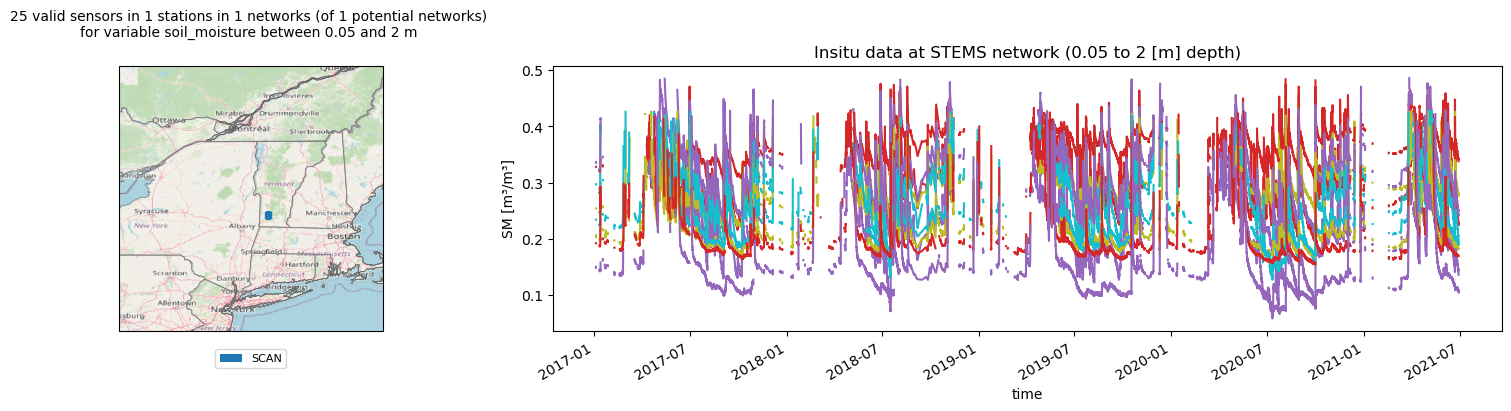

In [72]:
request = OSM()

ismn = ISMN_Interface(soil_moisture_path)
stems = None

depth = (0.05, 2)
def read_ismn(depth):
    min_depth, max_depth = depth

    fig = plt.figure(figsize=(15,4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    map_ax, ts_ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), fig.add_subplot(gs[0, 1:])
    
    # Plot a small overview map with station locations over Open Street Map
    ismn.plot_station_locations(variable='soil_moisture', min_depth=min_depth, max_depth=max_depth, markersize=5, text_scalefactor=2, stats_text=True, ax=map_ax)
    map_ax.set_extent([-77,-70,40,47])
    map_ax.add_image(request, 6)
    outline.plot(ax=map_ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=map_ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=map_ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    

     # Extract the sensors in the chosen depths at the locations and store their data
    sensors = []
    for network, station, sensor in ismn.collection.iter_sensors(variable='soil_moisture', depth=(min_depth, max_depth)):
        data = sensor.read_data()
        data.loc[data['soil_moisture_flag'] != 'G', 'soil_moisture'] = np.nan
        data = data['soil_moisture']
        if sensor.depth[0] == sensor.depth[1]:
            depth = f"{sensor.depth[0]}"
        else:
            depth = f"{sensor.depth[0]}-{sensor.depth[1]}"
        data.name = f"{station.name} ({depth} m)"
        sensors.append(data)
    
    global stems
    stems = pd.concat(sensors, axis=1)
    
    stems_plot = stems.loc['2017-01-01':,:]
    
    p = stems_plot.plot(ax=ts_ax, xlabel='time', ylabel='SM [m³/m³]', title=f'Insitu data at STEMS network ({min_depth} to {max_depth} [m] depth)')
    p.legend().remove()

read_ismn(depth)

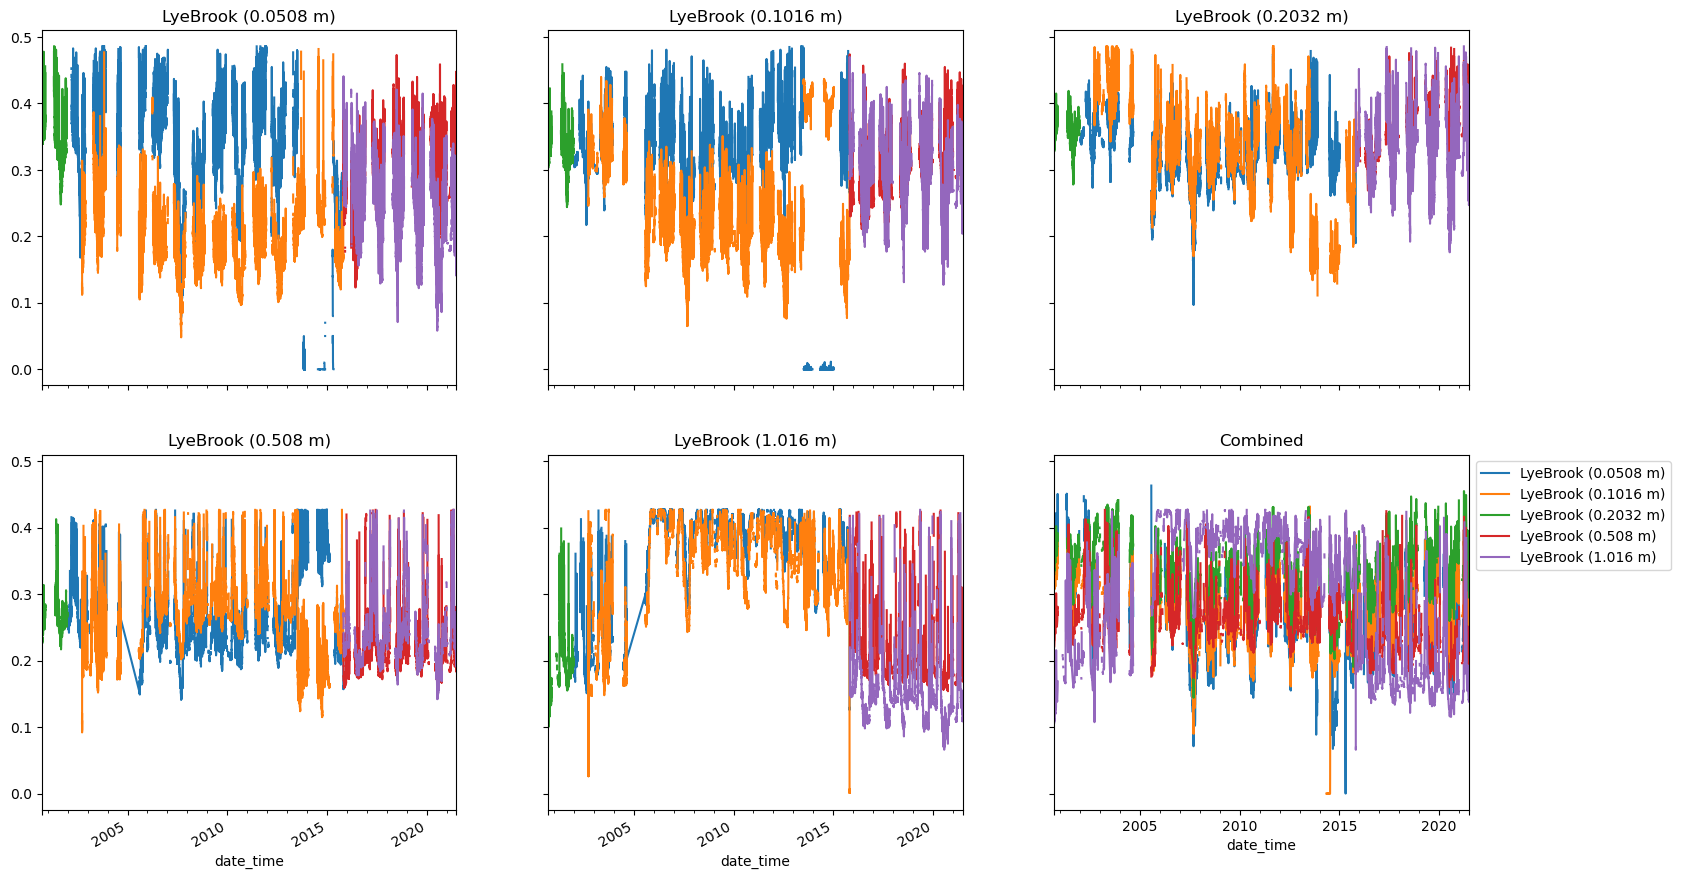

In [73]:
unique_val_cols = stems.columns.unique()
n = len(unique_val_cols)
fig, ax = plt.subplots(int((n+1)/3),3,figsize=(15,10),sharex=True,sharey=True)
fig.tight_layout(w_pad=5, h_pad=5)
lst_dfs = []
ax = ax.flatten()
for index, col in enumerate(unique_val_cols):
    df_depth = stems[col]
    lst_dfs.append(pd.DataFrame(data=df_depth.mean(axis=1).resample("d").mean(),columns=[col]))
    df_depth.plot(ax=ax[index])
    ax[index].legend().remove()
    ax[index].set_title(col)
stems_merged = pd.concat(lst_dfs,axis=1)
stems_merged.plot(ax=ax[-1])
ax[-1].legend(bbox_to_anchor=(1,1))
ax[-1].set_title("Combined");

The plot above shows the uncertainty in the data as different sensors report differently over time. Daily averages can be obtained by taking the mean of the observations and then resampelinig on a daily basis. 

### Microwave remote sensing -  Soil Moisture Active Passive Mission (SMAP)

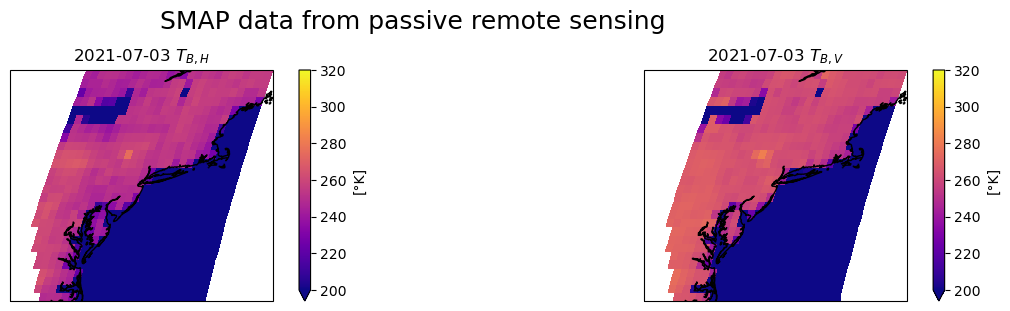

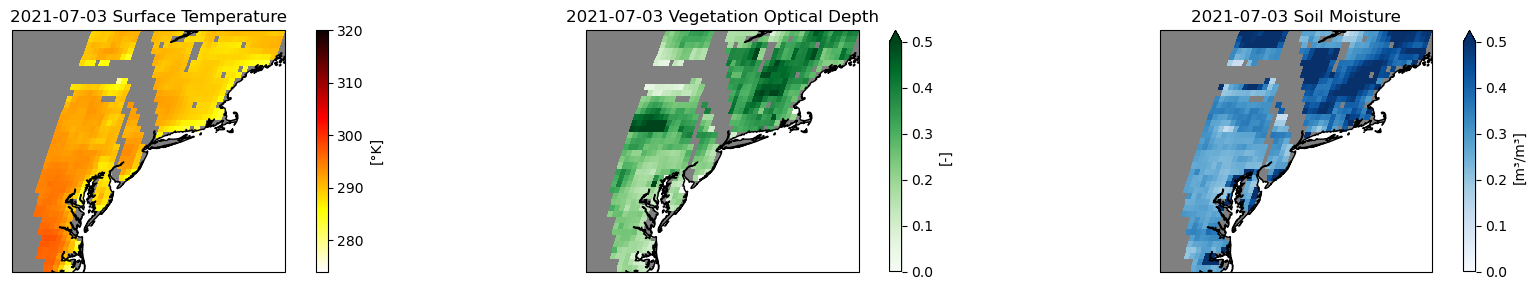

In [75]:
year,month,day  = 2021, 7, 3
date = f'{year}-{month:02}-{day:02}'

y = 40.48908101650877
x = -74.0305856727883
n_x = 5
n_y = n_x

smap_raw = xr.open_dataset(f'{ENVM1502_data_path}/LTC_DATA/SMAP_raw_202107.nc').sel(lon=slice(x - n_x, x + n_x),
                lat=slice(y + n_y, y - n_y))
smap_lprm = xr.open_dataset(f'{ENVM1502_data_path}/LTC_DATA/SMAP_LPRM_202107.nc').sel(lon=slice(x - n_x, x + n_x),
                lat=slice(y - n_y, y + n_y))

def plot_lprm(day):
    """
    Select and visualise SMAP data at a given time
    """
    date = f'2021-07-{day:02}'
    
    fig, axs = plt.subplots(1, 2, figsize=(15,3), subplot_kw={'projection': ccrs.Robinson()})
    
    fig.suptitle("SMAP data from passive remote sensing", fontsize=18, y=1.08)
    p1 = smap_raw['tbh'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[0],  cmap=plt.get_cmap('plasma'), vmin=200, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[0].set_title(f"{date} " "$T_{B,H}$")
    p2 = smap_raw['tbv'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[1],  cmap=plt.get_cmap('plasma'), vmin=200, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[1].set_title(f"{date} " "$T_{B,V}$")
                
    for p in [p1, p2]:
        p.axes.coastlines()
        
    fig, axs = plt.subplots(1, 3, figsize=(18,3), subplot_kw={'projection': ccrs.Robinson()})

    
    p3 = smap_lprm['temperature'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[0], cmap=plt.get_cmap('hot_r'), vmin=274, vmax=320, cbar_kwargs={'label': '[°K]'})
    axs[0].set_title(f"{date} Surface Temperature")
    
    p4 = smap_lprm['vod'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[1], cmap=plt.get_cmap('Greens'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[-]'})
    axs[1].set_title(f"{date} Vegetation Optical Depth")
    
    p5 = smap_lprm['soil_moisture'].sel(time=date).plot(transform=ccrs.PlateCarree(), ax=axs[2], cmap=plt.get_cmap('Blues'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[m³/m³]'})
    axs[2].set_title(f"{date} Soil Moisture")
            
    for p in [p3, p4, p5]:
        p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
        p.axes.coastlines()
        
    plt.tight_layout()
    
plot_lprm(3)



### Combining passive & active -Copernicus Climate Data Service CCDS
#### Load esa data

_This takes quite long_

In [76]:
filelist=glob.glob(f'{ENVM1502_data_path}/CDS_DATA/cds_data_esa/C3S*.nc')

dt=[datetime.datetime.strptime(x.split('/')[-1].split('-')[-3], '%Y%m%d%H%M%S') for x in filelist]
df = pd.DataFrame({'filepath':filelist}, index=dt).sort_index()
stack = xr.open_mfdataset(df.filepath.values, engine='netcdf4',combine='nested', concat_dim='time')
dslon = stack['lon'].compute()
dslat = stack['lat'].compute()
dssm = stack['sm'].compute()
# dssm

Text(0.5, 1.0, 'Capurnicus Data from esa for 2018-06-03')

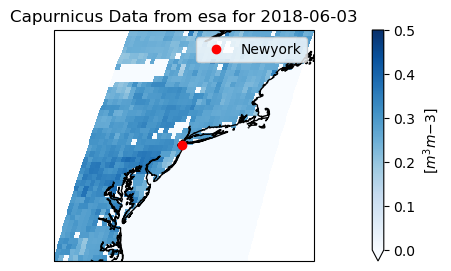

In [77]:
year  = 2018
month = 6
day   = 3
date = f'{year}-{month:02}-{day:02}'

y = 40.48908101650877
x = -74.0305856727883
n_x = 5
n_y = n_x
ny = dssm.sel(lon=slice(x - n_x, x + n_x),
                lat=slice(y + n_y, y - n_y),time=date)

fig, axs = plt.subplots(1, 1, figsize=(15,3), subplot_kw={'projection': ccrs.Robinson()})
ny.plot(transform=ccrs.PlateCarree(),ax=axs, cmap=plt.get_cmap('Blues'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[$m^{3} m{-3}$]'})
axs.plot(x,y,"ro",transform=ccrs.PlateCarree(),label="Newyork")

for p in [axs]:
    # p.axes.add_feature(cartopy.feature.LAND, zorder=0, facecolor='gray')
    p.axes.coastlines()

axs.legend();
axs.set_title(f"Capurnicus Data from esa for {date}")

# fig.savefig("output.png")


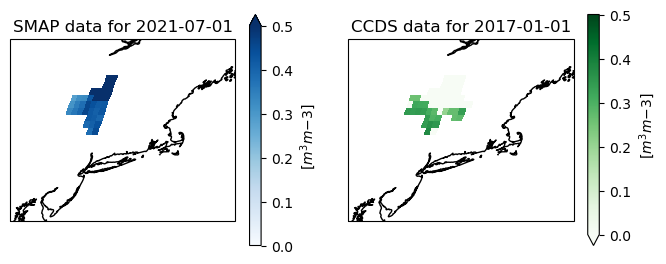

In [78]:
mask = regionmask.mask_geopandas(outline_buffered, 
                                 smap_lprm['soil_moisture'].lon.to_numpy(), 
                                 smap_lprm['soil_moisture'].lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

cropped_ds_smap = smap_lprm.where(mask==0)
cropped_ds_ccds = dssm.where(mask==0)

plot_ds_smap = cropped_ds_smap["soil_moisture"].isel(time=0)
plot_ds_ccds = cropped_ds_ccds.isel(time=0)

fig, [axs, axs2] = plt.subplots(1 ,2, figsize=(8,3), subplot_kw={'projection': ccrs.Robinson()})
plot_ds_smap.plot(transform=ccrs.PlateCarree(),ax=axs, cmap=plt.get_cmap('Blues'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[$m^{3} m{-3}$]'})
time =  cropped_ds_smap.isel(time=0).time.values
axs.set_title(f"SMAP data for {str(time)[:10]}")

plot_ds_ccds.plot(transform=ccrs.PlateCarree(),ax=axs2, cmap=plt.get_cmap('Greens'), vmin=0, vmax=0.5, cbar_kwargs={'label': '[$m^{3} m{-3}$]'})
time =  cropped_ds_ccds.isel(time=0).time.values
axs2.set_title(f"CCDS data for {str(time)[:10]}")

for p in [axs, axs2]:
    p.axes.coastlines()
    outline.plot(ax=p, edgecolor="C3", facecolor="None",transform=ccrs.PlateCarree())
    p.set_xlim((p.get_xlim()[0]+300000,p.get_xlim()[1]))
    p.set_ylim((p.get_ylim()[0]+350000,p.get_ylim()[1]+10000))


Text(0.5, 1.0, 'CCDS data compared to insitu observations')

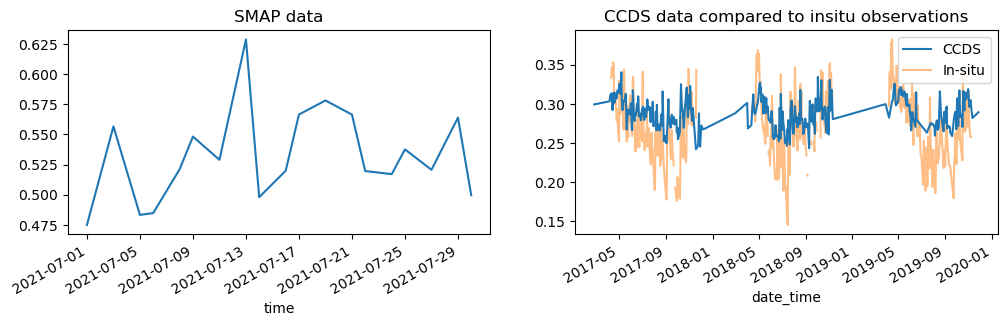

In [79]:
ds_mean_smap = cropped_ds_smap.mean(dim=["lat","lon"])
series_smap_sm = ds_mean_smap["soil_moisture"].to_pandas()
series_smap_sm_pos = series_smap_sm[series_smap_sm> 0]

ds_mean_ccds = cropped_ds_ccds.mean(dim=["lat","lon"])
series_ccds_sm = ds_mean_ccds.to_pandas()
series_ccds_sm_pos = series_ccds_sm[series_ccds_sm> 0]


fig, [ax, ax2] = plt.subplots(1,2,figsize=(12,3))
series_smap_sm_pos.plot(ax=ax)
ax.set_title('SMAP data')


series_ccds_sm_pos.plot(ax=ax2,label="CCDS")
stems_merged.loc[series_ccds_sm_pos.index.min():series_ccds_sm_pos.index.max()]["LyeBrook (0.0508 m)"].plot(ax=ax2, alpha=0.5,zorder=-1,label="In-situ")
ax2.legend()
ax2.set_title('CCDS data compared to insitu observations')

The plots above show the different products. The ccds show some promising data when conmpared with the ground obersvation data. Obtaining SMAP data for the same period wasn't possible. 

# 2.4 - Grace data & DEMs

Dems have been used throughout, see GIS images

In [80]:
files = glob.glob(f"{data_folder_grace}\\*.txt")
cnes_grgs = pd.read_csv(files[1], skiprows=45, skipinitialspace=True, delimiter=' ', index_col=['Time (years)'],
                        names=['Time (seconds since 1970/01/01)', 'Time (days since 1950/01/01)','Time (years)', 'Equivalent Water Heights (cm)',
                               'Linear model (cm)', 'Periodic model (cm)'])
cost_g = pd.read_csv(files[2], skiprows=45, skipinitialspace=True, delimiter=' ', index_col=['Time (years)'],
                        names=['Time (seconds since 1970/01/01)', 'Time (days since 1950/01/01)','Time (years)', 'Equivalent Water Heights (cm)',
                               'Linear model (cm)', 'Periodic model (cm)'])
jpl = pd.read_csv(files[3], skiprows=45, skipinitialspace=True, delimiter=' ', index_col=['Time (years)'],
                        names=['Time (seconds since 1970/01/01)', 'Time_days_since','Time (years)', 'Equivalent Water Heights (cm)',
                               'Linear model (cm)', 'Periodic model (cm)'])

jpl['Time days'] = jpl.apply(lambda x: pd.Timestamp('1950-01-01') + datetime.timedelta(x.Time_days_since), axis=1)
jpl_1 = jpl.copy()
jpl_1.set_index(['Time days'], inplace=True)
jpl_1.drop(inplace=True, columns=['Time (seconds since 1970/01/01)', 'Time_days_since', 'Linear model (cm)', 'Periodic model (cm)'])
jpl_1['Storage [mm]'] = jpl_1['Equivalent Water Heights (cm)'] * 10
jpl_1.drop(inplace=True, columns=['Equivalent Water Heights (cm)'])
jpl_1.to_parquet(f'{data_folder_grace}\\jplStorage.parquet')

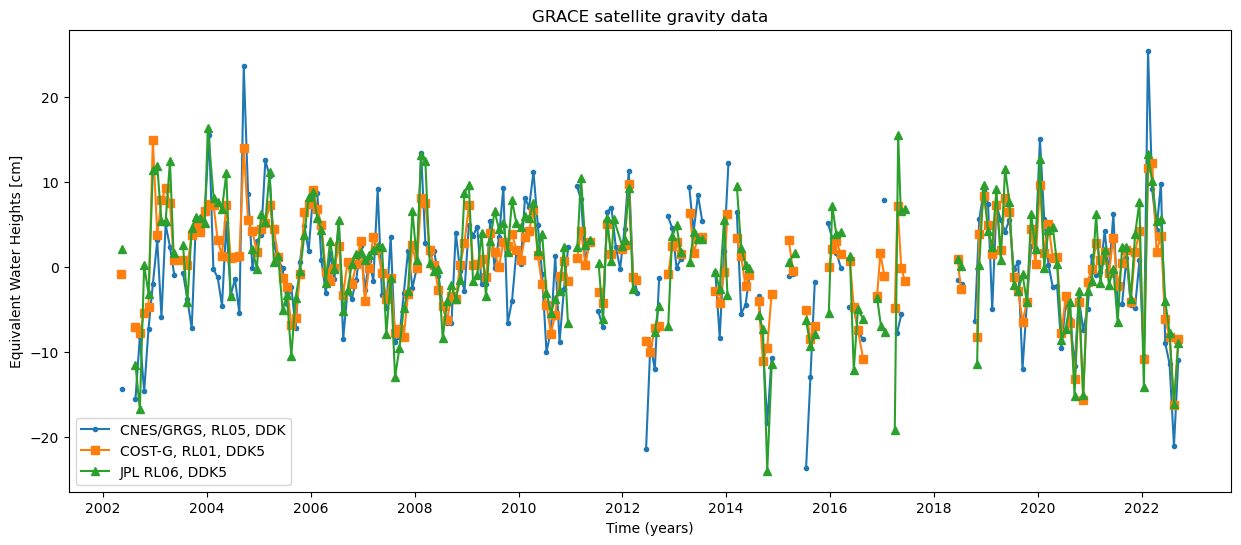

In [81]:
fig, ax = plt.subplots(figsize=(15,6))
cnes_grgs['Equivalent Water Heights (cm)'].plot(marker='.', label='CNES/GRGS, RL05, DDK')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=12, integer=True))
ax.set_ylabel('Equivalent Water Heights [cm]')
cost_g['Equivalent Water Heights (cm)'].plot(marker='s', label='COST-G, RL01, DDK5')
jpl['Equivalent Water Heights (cm)'].plot(marker='^', label='JPL RL06, DDK5')
ax.set_title('GRACE satellite gravity data')
ax.legend();

#### GRACE (Gravity  Recovery And Climate Experiment)

Grace data is obtained by a pair of satellites which follows each other on a polar orbit. The satellites are situated on a alitude of 500km and a distance of 220 km from each other. The plotted time series are created by three different groups. 

- CNES/GRGS: French National Space Center/ Research Group for Space Geodesy in Toulouse
- COST-G: Combination Service for Time-variable Gravity Fields consortium
- JPL: Jet Propulsion Laboratory, in Pasadena, California

As can be seen, the COST-G model shows peaks with less magnitude compared to the other 2 models. 

Overall, the water height is changing within a year.

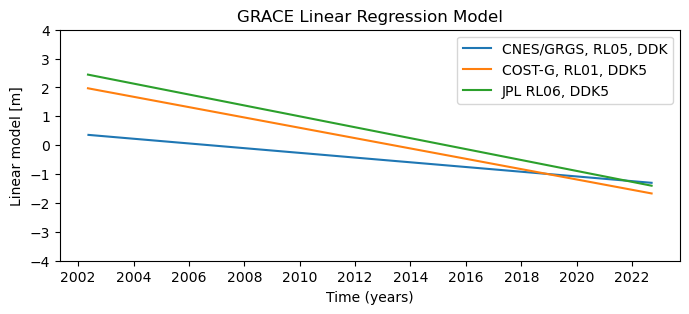

In [82]:
fig, ax = plt.subplots(figsize=(8,3))
cnes_grgs['Linear model (cm)'].plot( label='CNES/GRGS, RL05, DDK')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=12, integer=True))
ax.set_ylabel('Linear model [m]')
cost_g['Linear model (cm)'].plot(label='COST-G, RL01, DDK5')
jpl['Linear model (cm)'].plot(label='JPL RL06, DDK5')
ax.set_title('GRACE Linear Regression Model')
ax.legend()
ax.set_ylim((-4, 4));

All three models show a decreasing trend in water height over past 20 years. 

# 2.5- Evaporation from Remote sensing

landsat was tried first

In [83]:
ds = xr.open_dataset(data_folder + '\\EP\\landsat.nc')

<GeoAxesSubplot: title={'center': 'time = 2023-03-10'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

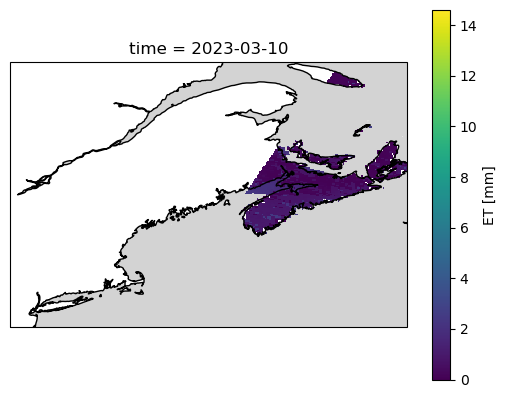

In [84]:
# to avoid showing warnings of cartopy
import warnings
warnings.filterwarnings('ignore')

pvar = ds.ET.isel(time=0)
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest')
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightgray')
ax.set_xlim((-75,-60))
ax.set_ylim((40,50))
outline.plot(ax=ax)

clearly falls outside our area, thus try another product

### Use era5 data:
code for automatic data retrieval is availible in notebook [2.5](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/2.5.EP_loading%20from%20remotesensing.ipynb) but was ommited for space reason

These are large files so are not in the project folder, but processed data is availible

In [85]:
year = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010']
path = f"C:\\Users\\david\\Documents\\EP_data_ENVM1502\\Era5_{year[0]}-{year[-1]}.nc"
ds = xr.open_dataset(path)
ds.pev.values[ds.pev.values > 0] = 0
cmap = mpl.cm.get_cmap("RdBu")

We want to crop our region out of the mask as it currently includes a lot of ocean, when we take the mean, this causes discrepancies

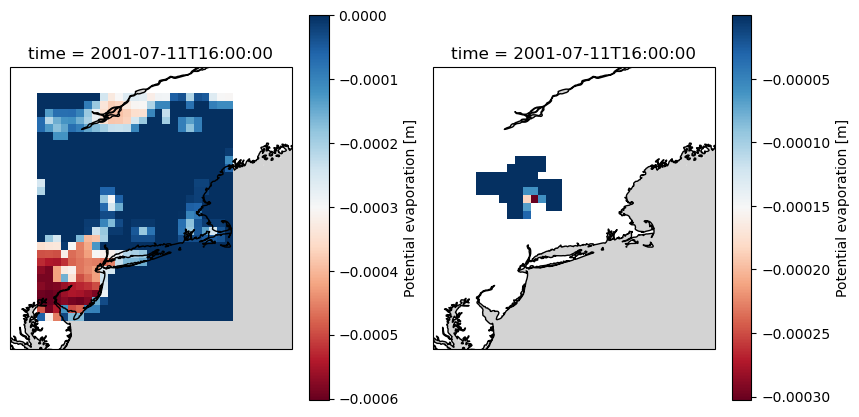

In [86]:
pvar = ds.pev.isel(time=4600)
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 

fig = plt.figure(figsize=(10,5))
ax =  fig.add_subplot(121,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest',cmap=cmap)
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightgray')
ax.set_xlim((-77,-68))
ax.set_ylim((38,47))
outline.plot(ax=ax, edgecolor="C3", facecolor="None")

# cropping
lon = np.arange(-76, -70+0.25, 0.25)
lat = np.arange( 39,  46+0.25, 0.25)
mask = regionmask.mask_geopandas(outline_buffered, lon, lat,lon_name="longitude",lat_name="latitude")
cropped_ds = ds.where(mask==0)

pvar = cropped_ds.pev.isel(time=4600)
pvar.plot.imshow(ax=ax2, transform=ccrs.PlateCarree(),interpolation='nearest',cmap=cmap)
ax2.coastlines()
ax2.add_feature(cartopy.feature.OCEAN, facecolor='lightgray')
ax2.set_xlim((-77,-68))
ax2.set_ylim((38,47))
outline.plot(ax=ax2, edgecolor="C3", facecolor="None");

Take mean & resample

In [87]:
ds_combine_mean = cropped_ds.mean(dim=["latitude","longitude"])
ds_combine_daily = ds_combine_mean.resample(time="1D").sum()

Export to df to be used & repeat for all years

In [88]:
series_pev = ds_combine_daily.pev.to_pandas()
df_pev = pd.DataFrame(data=series_pev,columns=["Pev"])
df_pev.Pev = df_pev.Pev * - 1000 # m -> m & evap is evaporation is negative as it leaves the earth
df_pev.index = df_pev.index - datetime.timedelta(hours=6)

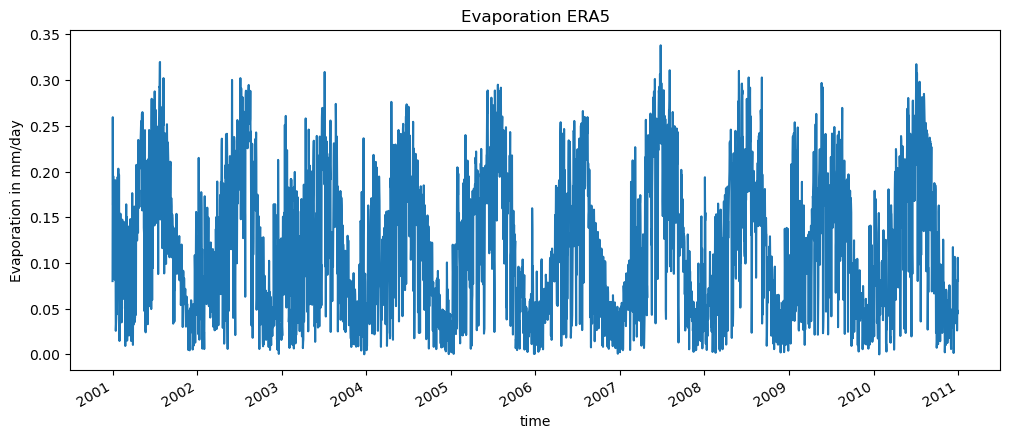

In [89]:
fig, ax = plt.subplots(1, figsize=(12,5))
df_pev["Pev"].plot(ax=ax)
ax.set_title("Evaporation ERA5")
ax.set_ylabel("Evaporation in mm/day");

Era5 seems very low which we dont fully understand, explored more in 2.6

# 2.6 - Data assimilation

##### quite a bit of work has been done to prepare all the data:
- [2.6.0](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/2.6.0.Data_assimilation-GoogleEE-IMERG-MODIS-GRACE%20data.ipynb) collects all the data using the google earth engine for IMERG, MODIS & GRACE
- [2.6.1](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/2.6.1.Data_assimilation-GLEAM.ipynb) loads in monthly GLEAM evaporation data obtained from their sstp server between 1980-2020
- [2.6.2](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/2.6.2.Data_assimilation-loading-all-GLEAM.ipynb) repeats this process for all the daily gleam data between 1980 - 2020, this data is large (17Gbs) thus only the processed data is included.


Only the results are shown here (still reproducible), see notebook [2.6.7](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/2.6.7.Data_assimilation.ipynb) for more detail. 

## load data
limit to 2010-2015 due to storage constraints <br>
**P** - ERA 5 obtained form ESMValTool - Forcings for the HBVmountain hydrological model: *with thanks to Rolf Hut*

In [90]:
ds_era5 = xr.load_dataset(f"{data_folder}\\ERA5_Group18_2010_2015.nc")
mask = regionmask.mask_geopandas(outline_buffered, 
                                 ds_era5['pr'].lon.to_numpy(), 
                                 ds_era5['pr'].lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")
cropped_ds_era5 = ds_era5.where(mask==0)

# Pr in "kg m-2 s-1" -> *86400 mm/d
pr_series = cropped_ds_era5["pr"].mean(dim=["lat","lon"]).to_pandas() * 86400 
df_era5_P = pd.DataFrame(pr_series,columns=["pr"]).rename(columns={"pr":"era5"})

In [91]:
IMERG = pd.read_parquet(f"{data_folder}\\P\\IMERG.parquet").rename(columns={"P":"IMERG"})

In [92]:
files = glob.glob(f"{data_folder}\\combined*.parquet")
df_all_data = pd.read_parquet(files[0]).loc["2010":"2015"]
station_data = df_all_data[["P"]].rename(columns={"P":"station"})

In [93]:
monlthy_p = [df_era5_P.resample("m").sum(), IMERG.resample("m").sum(), station_data.resample("m").sum()]
df_p = pd.concat(monlthy_p,axis = 1).loc["2010-03":"2014"]

# Compute monthly mean mP and variance vP of precipitation
df_p["mp"] = df_p.apply(lambda x: np.mean([x[f"{col}"] for col in x.index]),axis=1)
df_p["vp"] = df_p.apply(lambda x: (np.sum([(x[f"{col}"] - x.mp)**2 for col in x.index]))/(len(x.index)-1), axis=1)
df_p["sp"] = df_p.apply(lambda x: np.sqrt(x.vp) ,axis=1)

**E** - Load in EP from data collected already

In [94]:
ERA5_E = pd.read_parquet(f"{data_folder}\\EP\\combined_PE.parquet").rename(columns={"Pev":"Era5"}).resample('m').sum()

In [95]:
MODIS = pd.read_parquet(f"{data_folder}\\EP\\MODIS.parquet").dropna()
MODIS["PET"] = MODIS["PET"] * 0.1 # "kg/m^2/8day"  -> mm: scale factor 0.1

In [96]:
MODIS_monthly = MODIS.resample('m').sum()
MODIS_monthly.rename(columns={"PET":"MODIS"},inplace=True)

In [97]:
GLEAM = pd.read_parquet(f"{data_folder}\\EP\\GLEAM.parquet").loc["2010":"2015"].rename(columns={"Pe":"GLEAM"})

In [98]:
df_e = pd.concat([ERA5_E,MODIS_monthly, GLEAM],axis=1).loc["2010-03":"2014"]

# Compute monthly mean mE and variance vE of evaporation
df_e["me"] = df_e.apply(lambda x: np.mean([x[f"{col}"] for col in x.index]),axis=1)
df_e["ve"] = df_e.apply(lambda x: (np.sum([(x[f"{col}"] - x.me)**2 for col in x.index]))/(len(x.index)-1), axis=1)
df_e["se"] = df_e.apply(lambda x: np.sqrt(x.ve),axis=1)

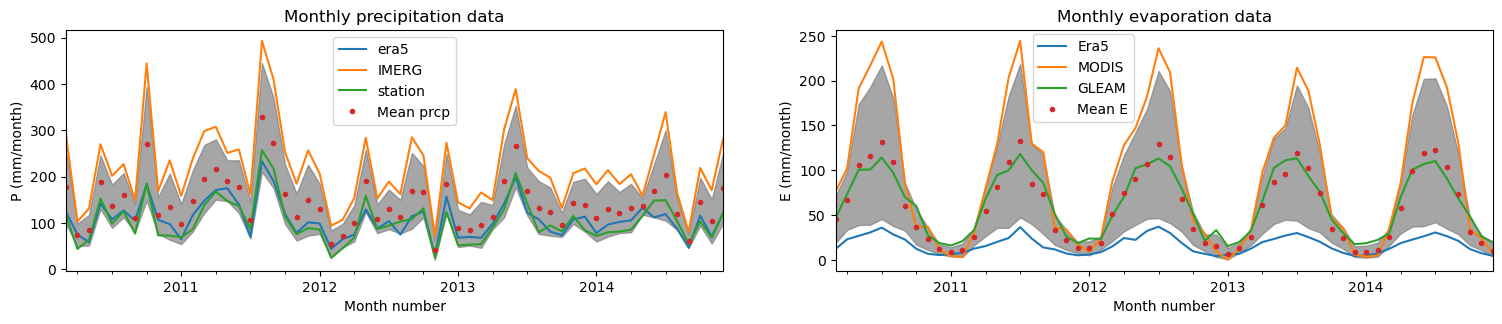

In [99]:
fig, [ax2, ax] = plt.subplots(1,2, figsize=(15,3))
fig.tight_layout(w_pad=5)

df_e[["Era5","MODIS","GLEAM"]].plot(ax=ax)
df_e['me'].plot(ax=ax,lw=0,color="C3",marker=".",label="Mean E")
ax.fill_between(df_e.index,(df_e["me"]+df_e["se"]).values,(df_e["me"]-df_e["se"]).values,color="grey",alpha=0.7)
ax.set_title("Monthly evaporation data") 
ax.set_ylabel("E (mm/month)")
ax.set_xlabel("Month number");
ax.legend(bbox_to_anchor=(0.464,0.588))

df_p[["era5","IMERG","station"]].plot(ax=ax2)
df_p['mp'].plot(ax=ax2,lw=0,color="C3",marker=".",label="Mean prcp")
ax2.fill_between(df_p.index,(df_p["mp"]+df_p["sp"]).values,(df_p["mp"]-df_p["sp"]).values,color="grey",alpha=0.7)
ax2.set_title("Monthly precipitation data") 
ax2.set_ylabel("P (mm/month)")
ax2.set_xlabel("Month number")
ax2.legend();

Here we see the issue with the era 5 evaporation data

**Q** - station data already prepared

In [100]:
df_q = df_all_data[["Q"]].resample("m").sum().loc["2010-03":"2014"]
# Compute monthly mean mQ and variance vQ of river discharge
df_q["mq"] = df_q.apply(lambda x: np.mean([x[f"{col}"] for col in x.index]),axis=1)
df_q["vq"] = df_q.apply(lambda x: 0.1 * x.mq, axis=1)
df_q["sq"] = df_q.apply(lambda x: np.sqrt(x.vq),axis=1)

**S** - from Earth engine

In [101]:
df_GRACE = pd.read_parquet(f"{data_folder}\\Grace\\GRACE.parquet").loc["2010-03":"2014"]
df_GRACE_error = pd.read_parquet(f"{data_folder}\\GRace\\GRACE_error.parquet").loc["2010-03":"2014-12"]

Bit of data management & magic to get it working with the others. Due to missing data there is some uncertainty in this method

In [102]:
df_s_in = pd.concat([df_GRACE,df_GRACE_error],axis=1).resample("m").mean()
wanted_index = df_q.apply(lambda x: f'{x.name.year}-{x.name.month}', axis=1).copy()
curent_index = df_s_in.apply(lambda x: f'{x.name.year}-{x.name.month}', axis=1)
df_index = pd.DataFrame(wanted_index).reset_index().set_index(0).rename(columns={"index":"fulldate"})
df_missing = df_index.loc[list(set(wanted_index.values).difference(set(curent_index.values)))].sort_values("fulldate").set_index("fulldate")
df_missing['graceJPL'] = 0
df_missing['graceJPLerror'] = 10**9
df_s = pd.concat([df_s_in,df_missing[['graceJPL','graceJPLerror']]])
df_s["graceJPL"]  = df_s.apply(lambda x: 0 if np.isnan(x.graceJPL) else x.graceJPL, axis=1)
df_s["graceJPLerror"]  = df_s.apply(lambda x: 10**9 if np.isnan(x.graceJPLerror) else x.graceJPLerror, axis=1) 

In [103]:
# Compute monthly mean mS and variance vS of water storage
df_s["ms"]  = df_s.apply(lambda x: x.graceJPL if not np.isnan(x.graceJPL) else 0, axis=1) # 0  
df_s["ss"]  = df_s.apply(lambda x: x.graceJPLerror if x.graceJPLerror > -9999 else np.nan, axis=1) #10**9 if np.isnan(x.graceJPLerror) else 
df_s["vs"]  = df_s.apply(lambda x: x.graceJPLerror**2 if x.graceJPLerror > -9999 else 10**9, axis=1) #10**9 if np.isnan(x.graceJPLerror) else 

**then run the algorithm**

In [104]:
def gaussian_product(m1, v1, m2, v2):
    w1 = v2 / (v1 + v2)
    w2 = v1 / (v1 + v2)
    m = w1 * m1 + w2 * m2
    v = w1 * v1 
    # print(v, w2*v2)
    if not np.isclose(v, w2 * v2):
        print(f"Issue with V2, should be same {v}, {w2 * v2}")
        raise AssertionError
    return m, v

In [105]:
def close_water_balance(mP, vP, mE, vE, mQ, vQ, mS, vS):
    # Specify prior mean and variance for initial storage S0 (first month)
    mS0 = 0
    vS0 = 200 * 200#large variance to indicate large uncertainty
    # print([len(mP), len(vP),len(mE), len(vE), len(mQ), len(vQ), len(mS), len(vS)])
    # Initialize posteriors
    # We compute these in forward loop (filtering posteriors) and then update them in backward loop (smoothing posteriors)
    nt = len(mP)#number of months in time-series
    mPostP = np.zeros(nt)#posterior mean of precipitation in each month
    vPostP = np.zeros(nt)#posterior variance of precipitation in each month
    mPostE = np.zeros(nt)#etc...
    vPostE = np.zeros(nt)
    mPostQ = np.zeros(nt)
    vPostQ = np.zeros(nt)
    mPostS = np.zeros(nt)
    vPostS = np.zeros(nt)
    
    # Forward loop (filtering)
    for t in range(nt):
        if t != 0: # Step 1: predict - compute forward distribution to S
            mS0, vS0 = mPostS[t-1], vPostS[t-1]
        mS_1  =  mP[t] + mS0 - mE[t] - mQ[t]
        vS_1  =  vP[t] + vS0 + vE[t] + vQ[t]
        mPostS[t], vPostS[t] = gaussian_product(mS_1, vS_1, mS[t], vS[t]) # Step 2: update - compute filtering posterior of S        
    
    # Backward loop (smoothing)
    mToS, vToS = 0.0, 1e+9#represents backward distribution to S - initialize to wide Gaussian for last month
    for t in reversed(range(nt)):
        mPostS[t], vPostS[t] = gaussian_product(mPostS[t], vPostS[t], mToS, vToS) # Step 1: smoothing posterior of S
        
        mBackS, vBackS = gaussian_product(mToS, vToS, mS[t], vS[t])               # Step 2: posteriors of P, E, and Q  ### backwards S
        if t != 0:
            mS0, vS0 = mPostS[t-1], vPostS[t-1]
        else: 
            mS0, vS0 = 0, 200*200
        # Q = P - S + S0 - E
        mQ_1  =  mP[t] - mBackS + mS0 - mE[t]
        vQ_1  =  vP[t] + vBackS + vS0 + vE[t]
        mPostQ[t], vPostQ[t] = gaussian_product(mQ[t],vQ[t], mQ_1, vQ_1)
        # P  = S - S0 + E + Q
        mP_1  =  + mBackS - mS0 + mE[t] + mQ[t]
        vP_1  =  + vBackS + vS0 + vE[t] + vQ[t]
        mPostP[t], vPostP[t] = gaussian_product(mP[t],vP[t], mP_1, vP_1)
        # E  = P + S0 - Q -S 
        mE_1  =  mP[t] - mBackS + mS0  - mQ[t]
        vE_1  =  vP[t] + vBackS + vS0  + vQ[t]
        mPostE[t], vPostE[t] = gaussian_product(mE[t],vE[t], mE_1, vE_1)
        
        mToS = mBackS - mP[t] + mE[t] + mQ[t]                                     # Step 3: backward distribution to S0
        vToS = vBackS + vP[t] + vE[t] + vQ[t]
    
    mPostS0, vPostS0 = gaussian_product(mToS, vToS, mS0, vS0) # After backward loop: compute posterior mean and variance of S0 (initial storage first month)
    return mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0 # Return final water balance estimates (posterior means and variances of monthly estimates)

In [106]:
vals = close_water_balance(df_p["mp"].values, df_p["vp"].values, df_e["me"].values, df_e["ve"].values, df_q["mq"].values, df_q["vq"].values, df_s["ms"].values, df_s["vs"].values)
mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0 = vals

In [107]:
df_p["mPostP"],df_p["vPostP"],df_e["mPostE"],df_e["vPostE"] = mPostP,vPostP,mPostE,vPostE
df_q["mPostQ"],df_q["vPostQ"],df_s["mPostS"],df_s["vPostS"] = mPostQ,vPostQ,mPostS,vPostS

Due to small errors in the numerical methods the water balance has some erros but they are close enough to zero to call it a sucess (left plot). 

Right shows that the gleam data is the best overal when closing the monthly waterbalance. This has already be done above & this is why the basin falls so nicely on the budyko curve

Text(0.5, 0, 'Month number')

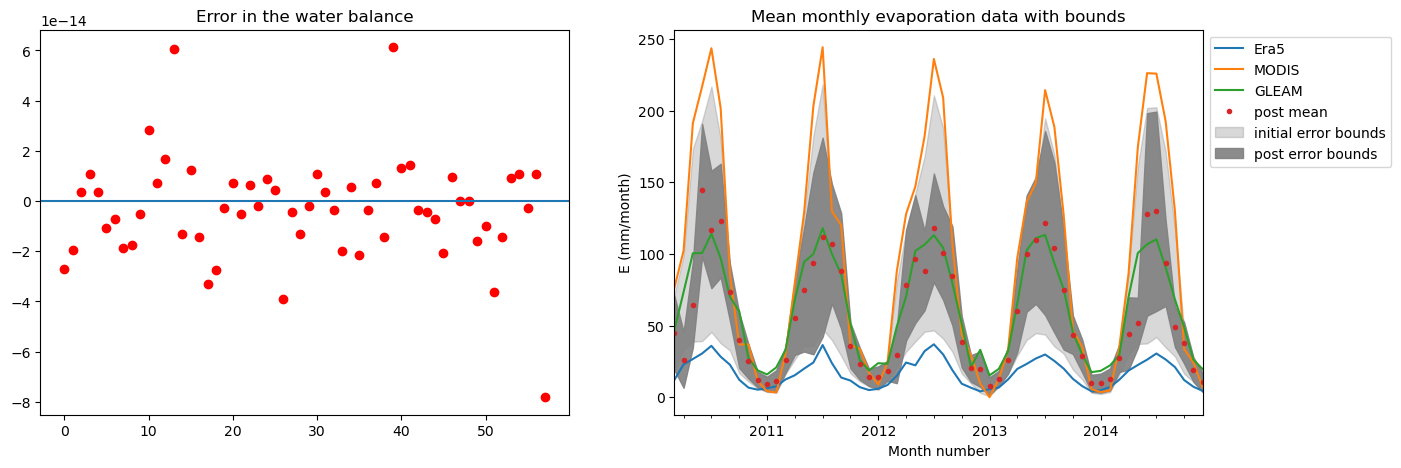

In [108]:
water_balance = np.zeros(len(mPostP))
storage_final = np.zeros(len(mPostP))

fig, [ax_l, ax] = plt.subplots(1,2,figsize=(15,5))
for t in range(len(mPostP)):
    if t == 0:
        S0 = mPostS0
    else:
        S0 = mPostS[t-1]
    water_balance[t] = mPostS[t] - mPostP[t]  + mPostE[t] + mPostQ[t] - S0
    storage_final[t] = mPostP[t]  - mPostE[t] - mPostQ[t] + S0
ax_l.plot(water_balance,"ro")
ax_l.axhline(0)
ax_l.set_title("Error in the water balance")

df_e[["Era5","MODIS","GLEAM"]].plot(ax=ax)
df_e['mPostE'].plot(ax=ax,lw=0,color="C3",marker=".",label="post mean")
ax.fill_between(df_e.index,(df_e["me"]+df_e["se"]).values,(df_e["me"]-df_e["se"]).values,color="grey",alpha=0.3, label="initial error bounds")
ax.fill_between(df_e.index,(df_e["mPostE"]+np.sqrt(df_e["vPostE"]).values),(df_e["mPostE"]-np.sqrt(df_e["vPostE"]).values),color="grey",alpha=0.9,label="post error bounds")

ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Mean monthly evaporation data with bounds") 
ax.set_ylabel("E (mm/month)")
ax.set_xlabel("Month number")

# 2.8 - Climate data

notebook [2.8](https://github.com/Daafip/ENVM1502-Catchment-model/blob/main/Python%20files/2.8.Climate_predictions.ipynb) provides an automated way to downlaod data, we will simply load it here

In [109]:
# This code shows one map
ifile = glob.glob(f'{data_folder}\\Climate Predictions\\*.nc')
ds_534 = xr.open_mfdataset(ifile[0]) # open dataset as x-array
ds_585 = xr.open_mfdataset(ifile[1]) # open dataset as x-array

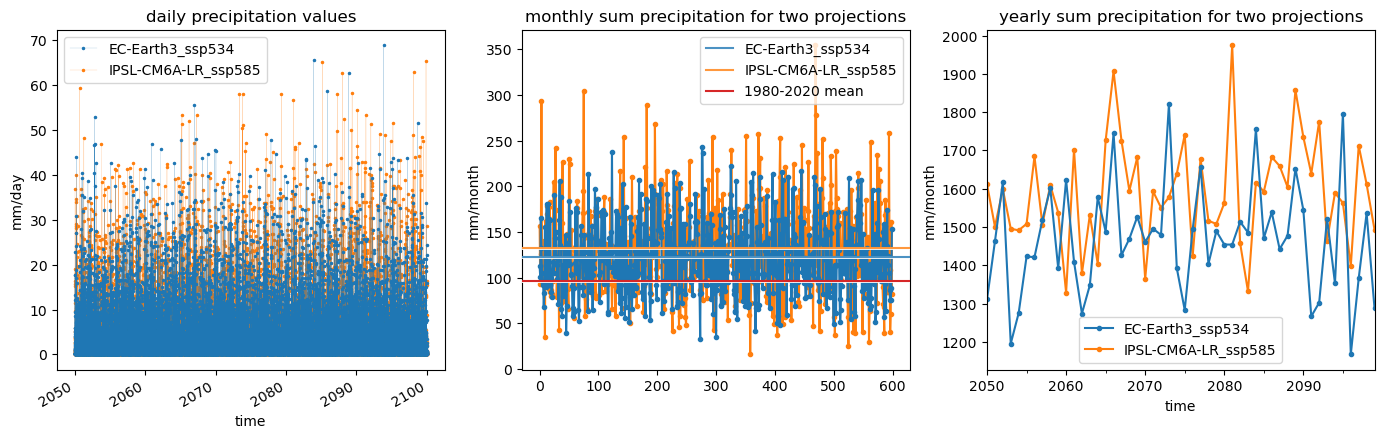

In [110]:
lst_series_out = []
names = ["EC-Earth3_ssp534","IPSL-CM6A-LR_ssp585"]
fig, [ax, ax2, ax3] = plt.subplots(1,3,figsize=(17,5))
for index, ds in enumerate([ds_534,ds_585]):
    mean_lat = ds.mean(dim="lat")
    mean_lat_lon = mean_lat.mean(dim="lon")
    series_out = mean_lat_lon.pr.to_pandas() * 86400
    series_out.plot(ax=ax, marker=".",markersize=3,lw=0.1,label=names[index],zorder=1-index)
    ax.set_title("daily precipitation values")
    ax.set_ylabel("mm/day")
    ax.legend()
    lst_series_out.append(series_out)

for index, series_out in enumerate(lst_series_out):    
    df = pd.DataFrame(data=series_out)
    ax2.axhline(df.resample("m").sum()[0].mean(),color=f"C{index}",label=names[index], alpha=0.8,lw=1.5,zorder=5)
    ax2.axhline(df.resample("m").sum()[0].mean(),color="w",lw=2,zorder=4)
    df = df.resample("m").sum()
    ax2.plot(df[0].values,marker=".",zorder=1-index,color=f"C{index}")
    ax2.set_ylabel("mm/month")
    ax2.set_title("monthly sum precipitation for two projections")
ax2.axhline(combined_forcing[["P"]].resample("m").sum().mean().values,color="C3",lw=1.5,label="1980-2020 mean",zorder=5)
ax2.axhline(combined_forcing[["P"]].resample("m").sum().mean().values,color="w",lw=2,zorder=4)
ax2.legend()

for index, series_out in enumerate(lst_series_out):    
    df = pd.DataFrame(data=series_out)
    df.resample("y").sum().plot(ax=ax3,marker=".",label=names[index],zorder=1-index)
    ax3.set_ylabel("mm/month")
    ax3.set_title("yearly sum precipitation for two projections")
ax3.legend(names)

SSP585 shows a higher level of monthly rainfall than SSP534, showing increasing flood peaks could be an issue to look out for. At the same time the lower peaks are also more extreme

# 3 modeling